In [76]:
import news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

from threadpoolctl import threadpool_limits
from joblib import Parallel, delayed

from IPython.display import display, clear_output

import numpy.linalg as LA
import joblib
import random

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from dotenv import load_dotenv
from news_nlp.topics_detector.topics_naming import (
	load_prompt_from_yaml,
	infer_llm
)
import os
import json

In [2]:
# Global config
RANDOM_SEED = 31415

# Parameters TF-IDF
TFIDF_BEST_MAX_FEATURES = 30_000
TFIDF_BEST_MIN_DF = 5
TFIDF_BEST_MAX_DF = 0.7
TFIDF_BEST_NGRAM_RANGE = (1, 2)
# Parameters SVD
# SVD_BEST_N_COMPONENTS = 5
SVD_BEST_N_COMPONENTS = 50
# Parameters KMeans
KMEANS_BEST_N_CLUSTERS = 50
# Parameters Topics naming
N_TOP_TERMS = 50

# Load data

In [3]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  
0      Singer, activist Joan Baez becomes Kennedy Cen...       177  
1      'Nothing but problems': Shipwreck tear-down en...      5332  
2      Report: At least 13 dead in Istanbul bombings....       248  
3      Senate Republicans Pressure Joe Biden to Withd...      4920  
4      The Unwelcome Return of the Real Purveyors of ...      3894  
...                                                  ...       ...  
89923  An Interview with Mark Blaxill on the Autism T...      1998  
89924  Vietnam reconsiders methane-emitting rice amid...      9005  
89925  Shaker furniture: Clean by design. The Hancock...       262  
89926  53 pot shop lottery winners announced, includi...      2093  
89927  Singer Ani DiFranco on career, new album "Revo...       394  

[89928 rows x 5 columns]

In [4]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89928

# Vectorization with TF-IDF

In [5]:
"""
TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is
a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.
"""

'\nTF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is\na word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.\n'

## Full-vocabulary vectorization

In [6]:
# TF-IDF Vectorizer configuration
tfidf_full = TfidfVectorizer(
	max_features=None
)

In [7]:
X_full = tfidf_full.fit_transform(texts)
X_full.shape

(89928, 158998)

In [8]:
vocab_full = tfidf_full.get_feature_names_out()
vocab_full

array(['00', '000', '0000', ..., '晏宏', '温麟衍', 'ﬁle'],
      shape=(158998,), dtype=object)

In [9]:
term_freq = np.asarray(X_full.sum(axis=0)).ravel()
term_freq

array([4.69435942e+01, 5.39258810e+02, 9.05058664e-01, ...,
       4.82312353e-02, 1.67345636e-01, 1.04451748e-01], shape=(158998,))

In [10]:
sorted_idx = np.argsort(-term_freq)
freq_sorted = term_freq[sorted_idx]
vocab_sorted = vocab_full[sorted_idx]
vocab_sorted

array(['the', 'to', 'of', ..., 'crystallizes', 'monosodium',
       'candymakers'], shape=(158998,), dtype=object)

In [11]:
total_freq = freq_sorted.sum()
total_freq

np.float64(793884.1018772459)

In [12]:
coverage = np.cumsum(freq_sorted) / total_freq
coverage

array([0.01685862, 0.02649397, 0.03464927, ..., 0.99999999, 1.        ,
       1.        ], shape=(158998,))

In [13]:
def features_for_coverage(coverage_array, target):
	return int(np.searchsorted(coverage_array, target) + 1)

In [14]:
n_90 = features_for_coverage(coverage, 0.90)
n_95 = features_for_coverage(coverage, 0.95)
n_99 = features_for_coverage(coverage, 0.99)
n_999 = features_for_coverage(coverage, 0.999)
print(f"Number of features to cover 90% of the corpus: {n_90}")
print(f"Number of features to cover 95% of the corpus: {n_95}")
print(f"Number of features to cover 99% of the corpus: {n_99}")
print(f"Number of features to cover 99.9% of the corpus: {n_999}")

Number of features to cover 90% of the corpus: 15488
Number of features to cover 95% of the corpus: 28766
Number of features to cover 99% of the corpus: 76037
Number of features to cover 99.9% of the corpus: 136456


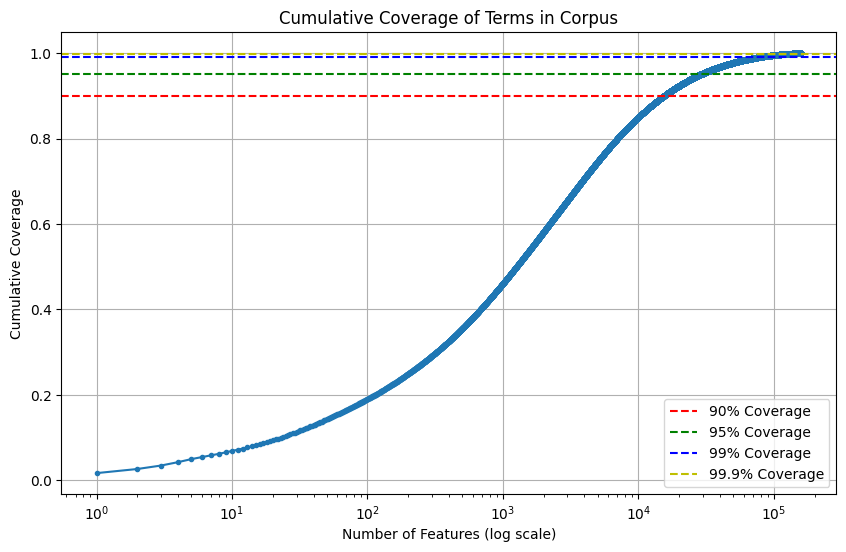

In [15]:
# Plot coverage curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Coverage')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Coverage')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% Coverage')
plt.axhline(y=0.999, color='y', linestyle='--', label='99.9% Coverage')
plt.xscale('log')
plt.xlabel('Number of Features (log scale)')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage of Terms in Corpus')
plt.legend()
plt.grid(True)
plt.show()

## Final vectorizer

In [16]:
if not os.path.exists(paths.X_TFIDF_JLIB):
	print("Creating X_tfidf from scratch...")
	# TF-IDF Vectorizer configuration
	tfidf = TfidfVectorizer(
		max_features=TFIDF_BEST_MAX_FEATURES,  	# Limits to top 30k features
		ngram_range=(1, 2),      				# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
		stop_words="english",	 				# Removes common English stop words (e.g., "the", "is", "and")
		min_df=5,                				# Words must appear in at least 5 documents to be included
		max_df=0.7               				# Words that appear in more than 70% of documents are discarded
	)
	# Fit and transform the texts to obtain the TF-IDF matrix
	X_tfidf = tfidf.fit_transform(texts)
	print(X_tfidf.shape)
	# Save the fitted TF-IDF vectorizer to disk
	joblib.dump(tfidf, paths.MODEL_NOTEBOOKS_TFIDF)
	# Save the TF-IDF matrix to disk
	joblib.dump(X_tfidf, paths.X_TFIDF_JLIB)
else:
	tfidf = joblib.load(paths.MODEL_NOTEBOOKS_TFIDF)
	print("Loaded existing TF-IDF vectorizer from disk.")
	X_tfidf = joblib.load(paths.X_TFIDF_JLIB)
	print(f"Loaded existing X_tfidf with shape: {X_tfidf.shape} from disk.")

Loaded existing TF-IDF vectorizer from disk.
Loaded existing X_tfidf with shape: (89928, 30000) from disk.


In [17]:
# Get feature names (words)
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

# Dimension reduction with Truncated SVD

In [18]:
"""
Reduce from TFIDF_BEST_MAX_FEATURES dimensions to SVD_BEST_N_COMPONENTS latent
components (LSA). This will reduce noise and make clustering faster and more stable.
"""

'\nReduce from TFIDF_BEST_MAX_FEATURES dimensions to SVD_BEST_N_COMPONENTS latent\ncomponents (LSA). This will reduce noise and make clustering faster and more stable.\n'

In [19]:
"""
Each dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).
Latent topics are linear combinations of the original features that capture underlying themes in the data.
This allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,
which will make subsequent clustering more efficient and potentially more meaningful.
"""

'\nEach dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).\nLatent topics are linear combinations of the original features that capture underlying themes in the data.\nThis allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,\nwhich will make subsequent clustering more efficient and potentially more meaningful.\n'

## Search for best hyperparameters

### Helper functions

In [20]:
def calculate_explained_variance(
	n_components_list: list[int],
	X_tfidf: np.ndarray,
	df_variance: pd.DataFrame | None = None,
	save_csv: bool = True,
	random_state: int = RANDOM_SEED
):
	
	# Initialize DataFrame if not provided
	if df_variance is None:
		if os.path.exists(paths.DF_VARIANCE):
			df_variance = pd.read_csv(paths.DF_VARIANCE)
		else:
			df_variance = pd.DataFrame(columns=["n_components", "explained_variance"])
	
	# Filter out n_components already evaluated
	existing = set(df_variance["n_components"].astype(int).tolist()) if not df_variance.empty else set()
	n_components_list = [k for k in n_components_list if k not in existing]

	if not n_components_list:
		return df_variance

	# Fit Truncated SVD with the maximum n_components needed
	svd = TruncatedSVD(
		n_components=max(n_components_list),
		random_state=random_state
	)

	# Fit SVD on the TF-IDF matrix
	print(f"Fitting Truncated SVD with n_components={max(n_components_list)}...")
	svd.fit(X_tfidf)
	
	# Calculate cumulative explained variance
	cum_exp_var = np.cumsum(svd.explained_variance_ratio_)
	
	# Collect results for specified n_components
	n_components = []
	explained_variances = []
	for k in n_components_list:
		ev = float(cum_exp_var[k - 1])
		n_components.append(k)
		explained_variances.append(ev)

	# Create DataFrame for new results
	df_results = pd.DataFrame({
		"n_components": n_components,
		"explained_variance": explained_variances
	})

	# Append new results to existing DataFrame
	df_variance = pd.concat([df_variance, df_results], ignore_index=True)

	# Sort by explained_variance
	df_variance = df_variance.sort_values(by="explained_variance", ascending=False).reset_index(drop=True)

	# Save to CSV if required
	if save_csv:
		df_variance.to_csv(paths.DF_VARIANCE, index=False)

	clear_output(wait=True)

	return df_variance	

In [21]:
def plot_explained_variance(
	df_variance: pd.DataFrame,
	tfidf_max_features: int = TFIDF_BEST_MAX_FEATURES,
) -> None:
	# Plot explained variance vs n_components
	plt.figure(figsize=(10, 6))
	plt.plot(df_variance["n_components"], df_variance["explained_variance"], marker='o')
	plt.xlabel('Number of Components (n_components)')
	plt.ylabel('Explained Variance Ratio')
	plt.title(f'Explained Variance vs Number of Components in LSA\n(TF-IDF max features: {tfidf_max_features})')
	plt.grid(True)
	plt.show()

In [22]:
def create_fit_transform_svd_pipeline(
	n_components: int,
	X_tfidf: np.ndarray,
	random_state: int = RANDOM_SEED,
) -> np.ndarray:

	# Initialize Truncated SVD
	svd = TruncatedSVD(
	n_components=n_components,
	random_state=random_state
	)

	# Normalizer helps to make distances for K-means more stable
	normalizer = Normalizer(copy=False)
	normalizer

	# Create a pipeline that first applies SVD and then normalizes the result
	svd_pipeline = make_pipeline(svd, normalizer)
	svd_pipeline

	# Fit and transform the TF-IDF matrix to obtain the reduced representation
	X_reduced = svd_pipeline.fit_transform(X_tfidf)

	# Calculate explained variance
	explained_var = svd.explained_variance_ratio_.sum()

	print(f"SVD Pipeline created with n_components={n_components}")
	print(f"Reduced data shape: {X_reduced.shape}")
	print(f"Explained variance: {explained_var:.4f}")

	return X_reduced

### Experimentation

Loading existing explained variance df from disk...


n_components  explained_variance
0          10000            0.859843
1           9000            0.839733
2           8000            0.815512
3           7000            0.786880
4           6000            0.752904
5           5000            0.709593
6           4500            0.687267
7           4000            0.661272
8           3500            0.631487
9           3000            0.597275
10          2500            0.557570
11          2250            0.535144
12          2000            0.510584
13          1750            0.483449
14          1500            0.453184
15          1250            0.419007
16          1000            0.379693
17           900            0.362082
18           800            0.343134
19           700            0.322613
20           600            0.300212
21           500            0.275496
22           400            0.247615
23           300            0.215277
24           200            0.175933
25           100            0.123074

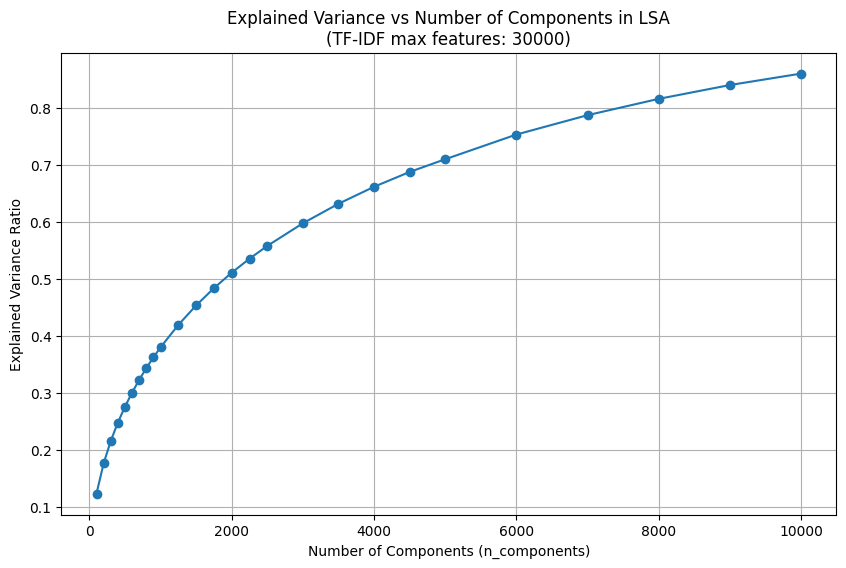

In [23]:
# If df_variance does not exist on disk, calculate it, otherwise load it
if not os.path.exists(paths.DF_VARIANCE):
	print("Calculating explained variance df for different n_components...")
	df_variance = pd.DataFrame(columns=["n_components", "explained_variance"])
	# Define the list of n_components values to evaluate
	n_components_list = (
		list(range(100, 1001, 100)) + 
		list(range(1250, 2501, 250)) + 
		list(range(3000, 5001, 500)) +
		list(range(6000, 10001, 1000))
	)
	# Calculate and save on disk explained variance df for different values of n_components
	df_variance = calculate_explained_variance(n_components_list, X_tfidf, df_variance)
else:
	print("Loading existing explained variance df from disk...")
	df_variance = pd.read_csv(paths.DF_VARIANCE)
display(df_variance)
plot_explained_variance(df_variance, tfidf_max_features=TFIDF_BEST_MAX_FEATURES)

## Final TruncatedSVD

In [24]:
n_components = SVD_BEST_N_COMPONENTS
# Create, fit and transform SVD pipeline for n_components
X_reduced = create_fit_transform_svd_pipeline(n_components, X_tfidf)

SVD Pipeline created with n_components=50
Reduced data shape: (89928, 50)
Explained variance: 0.0837


# Clustering with K-Means

In [25]:
"""
Now we can cluster the news articles in this reduced 100-dimensional space using
K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced 100-dimensional space using\nK-means clustering.\n'

## Search for best hyperparameters

### Helper functions

In [26]:
def evaluate_k(
	k_values,
	X,
	df_silhouette: pd.DataFrame | None = None,
	silhouette_sample_size: int | None = 1_000,
	n_jobs: int = -1,
	# kmeans_algorithm: str = "elkan",
):
	"""
	Trains K-means for each k in k_values and computes the silhouette score.
	Args:
		k_values (list): List of k values to evaluate.
		X (array-like): Data to cluster.
		df_silhouette (pd.DataFrame): DataFrame to append results to.
	Returns:
		results (list): List of dicts with k and silhouette score.
	"""

	if df_silhouette is None:
		if os.path.exists(paths.DF_SILHOUETTE):
			df_silhouette = pd.read_csv(paths.DF_SILHOUETTE)
		else:
			df_silhouette = pd.DataFrame(columns=["k", "silhouette", "inertia"])

	X_arr = np.asarray(X, dtype=np.float32)

	# Check for already evaluated k values and skip them
	existing = set(df_silhouette["k"].astype(int).tolist()) if len(df_silhouette) else set()
	k_values_to_run = [int(k) for k in k_values if int(k) not in existing]

	def _run_one_k(k: int) -> dict:
		
		# Limit internal OpenMP threads to 1 per process to avoid oversubscription
		with threadpool_limits(limits=1):
			
			# Initialize MiniBatchKMeans with specified parameters
			km = MiniBatchKMeans(
				n_clusters=k,
				init="k-means++",
				n_init="auto",
				max_iter=300,
				batch_size=2048,
				# algorithm=kmeans_algorithm,
                random_state=RANDOM_SEED,
			)

			# Fit K-means and predict cluster labels
			print(f"Fitting K-means for k={k}...")
			labels = km.fit_predict(X_arr)

			# Compute silhouette score
			print(f"Computing silhouette score for k={k}...")
			sil = silhouette_score(
				X_arr,
				labels,
				sample_size=silhouette_sample_size,
				random_state=RANDOM_SEED,
			)
			# Get inertia
			inertia = float(km.inertia_)

		# print(f"Evaluated k={k}: silhouette={sil:.4f}, inertia={inertia:.4f}")
		
		return {"k": k, "silhouette": float(sil), "inertia": inertia}

	if k_values_to_run:
		# Run evaluations in parallel
		results = Parallel(n_jobs=n_jobs, prefer="processes")(
			delayed(_run_one_k)(k) for k in k_values_to_run
		)

		# Append new results to the DataFrame
		df_silhouette = pd.concat([df_silhouette, pd.DataFrame(results)], ignore_index=True)

	# Order by silhouette descending
	df_silhouette = df_silhouette.sort_values(by="silhouette", ascending=False).reset_index(drop=True)

	# # Summary
	# for _, row in df_silhouette.iterrows():
	# 	print(f"k={int(row['k'])}, silhouette={row['silhouette']:.4f}, inertia={row['inertia']:.4f}")

	clear_output(wait=True)

	return df_silhouette

In [27]:
def plot_silhouette_inertia(
	df_silhouette: pd.DataFrame,
	tfidf_max_features: int = TFIDF_BEST_MAX_FEATURES,
	svd_n_components: int = SVD_BEST_N_COMPONENTS,
) -> None:
	"""
	Plots inertia and silhouette score vs number of clusters (k) with two y-axes.
	Args:
		df_silhouette (pd.DataFrame): DataFrame with k, silhouette, and inertia columns.
		tfidf_max_features (int): Number of TF-IDF features used.
		svd_n_components (int): Number of SVD components used.
	Returns:
		None
	"""

	# Reorder by k ascending
	df_silhouette = df_silhouette.sort_values(by="k").reset_index(drop=True)

	# Create figure and axis objects
	fig, ax1 = plt.subplots(figsize=(10, 5))

	# First axis Y (left)
	ax1.plot(df_silhouette["k"], df_silhouette["inertia"], marker="o", color="b", label="Inertia")
	ax1.set_xlabel("k")
	ax1.set_ylabel("Inertia", color="b")
	ax1.grid(True, alpha=0.3)

	# Second axis Y (right)
	ax2 = ax1.twinx()
	ax2.plot(df_silhouette["k"], df_silhouette["silhouette"], marker="o", linestyle="--", color="r", label="Silhouette Score")
	ax2.set_ylabel("Silhouette Score", color="r")

	# Combined legend (from both axes)
	lines1, labels1 = ax1.get_legend_handles_labels()
	lines2, labels2 = ax2.get_legend_handles_labels()
	ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

	plt.title(f"Inertia and Silhouette Score vs Number of Clusters (k)\n(TF-IDF max features: {tfidf_max_features}, SVD components: {svd_n_components})")
	plt.tight_layout()
	plt.show()

### Experimentation

In [28]:
"""
The silhouette score reaches an elbow around k=300, which suggests that increasing k further yields diminishing returns in cluster quality.
"""
selected_k = 300

#### Experiments starting with n_components = 5000

In [29]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=5000
"""

n_components = 5_000
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0   115    0.021492  80256.101562
1    92    0.020198  80489.320312
2   105    0.019303  80202.546875
3    58    0.019252  81900.296875
4   135    0.019247  79778.382812
..  ...         ...           ...
77    5    0.005520  86813.773438
78    7    0.005263  86469.609375
79    4    0.005165  86978.812500
80    3    0.004047  87479.523438
81    2    0.002751  87789.476562

[82 rows x 3 columns]

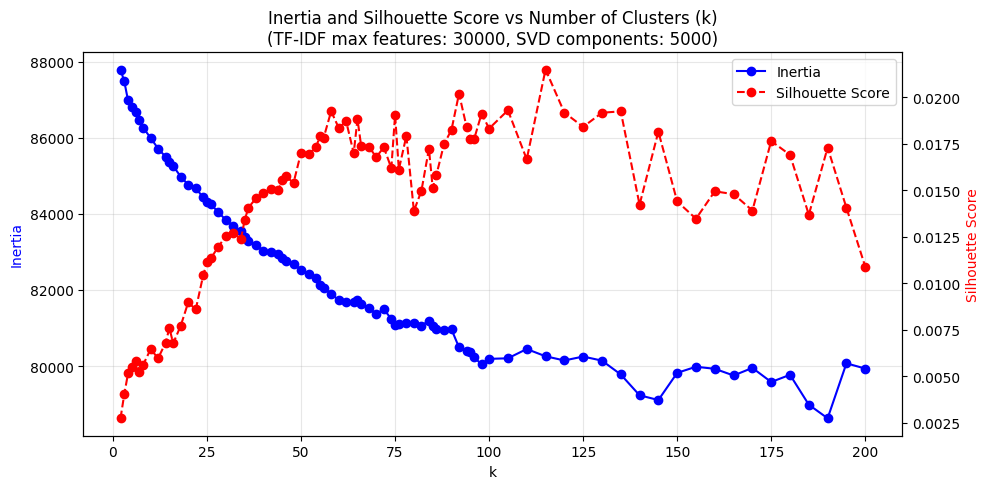

In [30]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=5000
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 5_000
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 99, 2)) + list(range(100, 201, 5))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
    df_silhouette_dict[svd_n_components],
    tfidf_max_features=tfidf_max_features,
    svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 500

In [31]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=500
"""

n_components = 500
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0    290    0.085083  54128.109375
1    292    0.084890  54115.738281
2    456    0.084570  49812.589844
3    296    0.084330  53936.289062
4    284    0.083884  54807.601562
..   ...         ...           ...
305   10    0.018679  80016.984375
306    6    0.018145  81557.984375
307    8    0.015483  80825.234375
308    4    0.014217  82602.804688
309    2    0.008891  84449.023438

[310 rows x 3 columns]

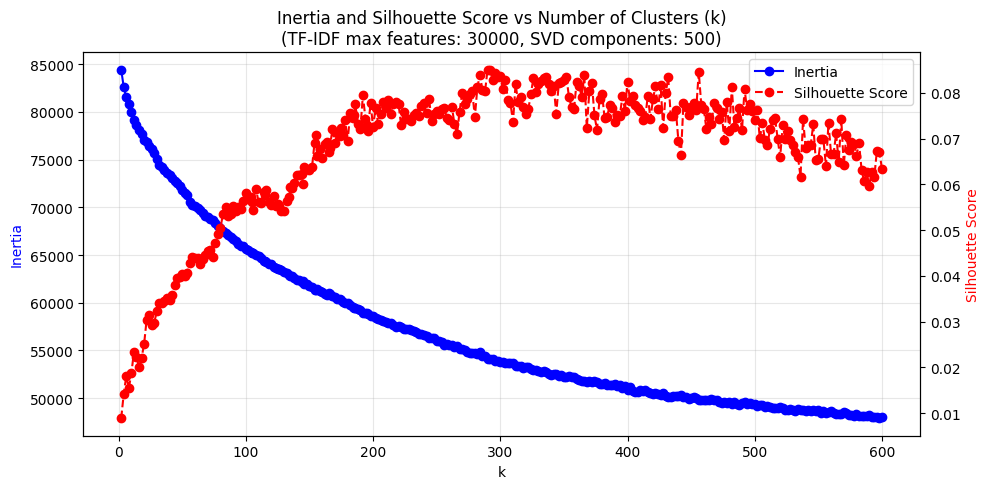

In [32]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=500
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 500
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 601, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
    df_silhouette_dict[svd_n_components],
    tfidf_max_features=tfidf_max_features,
    svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 100

In [33]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=100
"""

n_components = 100
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0     88    0.162606  40515.222656
1    108    0.158598  38176.804688
2    110    0.158026  37960.527344
3     94    0.158020  39979.839844
4     86    0.157628  41097.785156
..   ...         ...           ...
195   10    0.050753  66696.617188
196    6    0.043823  69717.460938
197    8    0.035942  69605.703125
198    4    0.032148  73667.328125
199    2    0.026911  76551.609375

[200 rows x 3 columns]

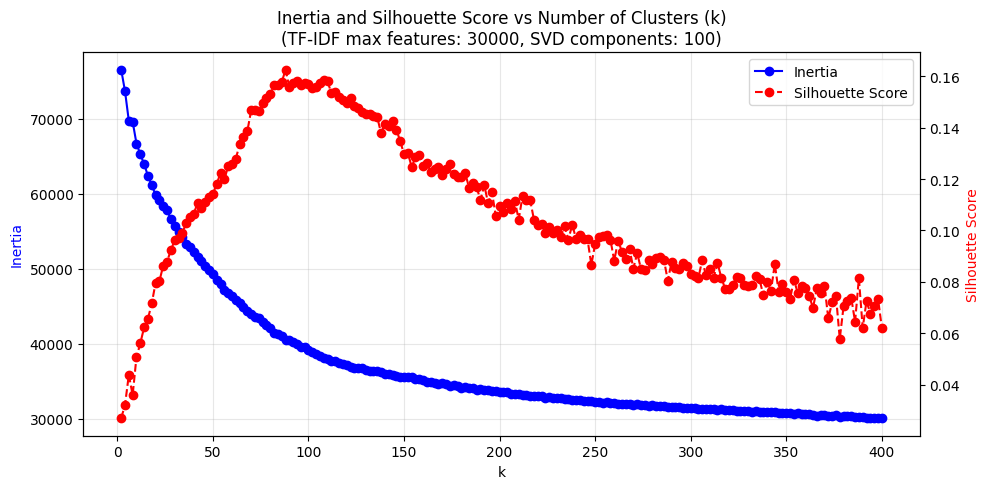

In [34]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=100
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 100
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
    df_silhouette_dict[svd_n_components],
    tfidf_max_features=tfidf_max_features,
    svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 50

In [35]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=50
"""

n_components = 50
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0     48    0.163532  35781.957031
1     50    0.161550  35134.425781
2     44    0.159313  36888.449219
3     46    0.159213  36369.531250
4     42    0.158293  37576.792969
..   ...         ...           ...
195  398    0.049022  22523.740234
196  348    0.048772  22974.593750
197  380    0.048388  22702.287109
198  384    0.048123  22648.369141
199    2    0.037066  70260.632812

[200 rows x 3 columns]

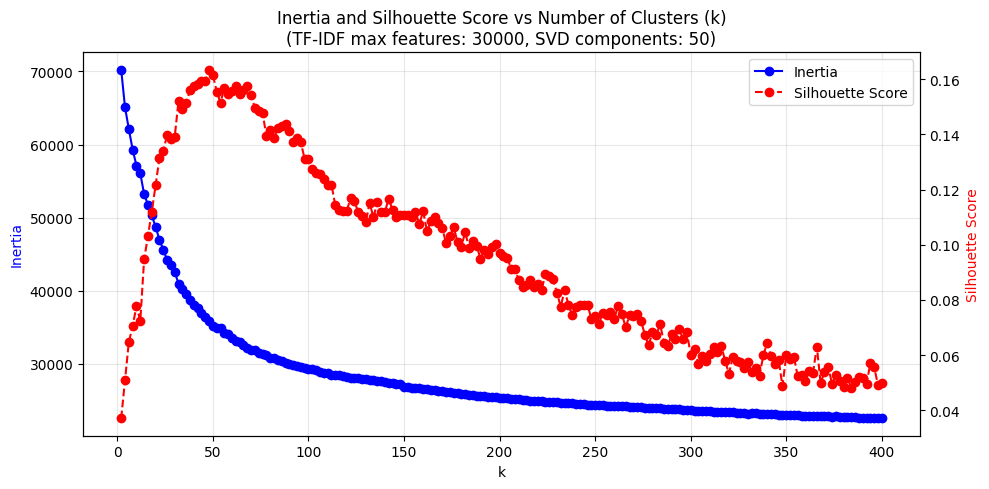

In [36]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=50
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 50
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
    df_silhouette_dict[svd_n_components],
    tfidf_max_features=tfidf_max_features,
    svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 5

In [37]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=50
"""

n_components = 5
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0      5    0.366919  12328.489258
1      4    0.360303  16438.980469
2      6    0.343088  10685.608398
3      8    0.327637   8817.355469
4      7    0.302005  10107.304688
..   ...         ...           ...
209  386    0.051443   1211.795898
210  376    0.051250   1232.835815
211  366    0.049026   1250.275513
212  372    0.044735   1237.747070
213  374    0.044162   1228.847046

[214 rows x 3 columns]

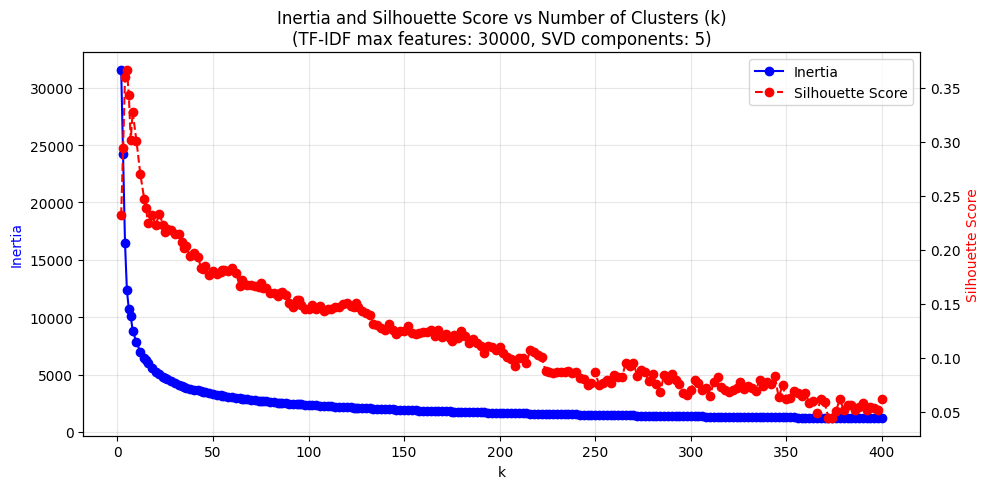

In [38]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=50
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 5
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
    df_silhouette_dict[svd_n_components],
    tfidf_max_features=tfidf_max_features,
    svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 40

In [39]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=5
"""

n_components = 40
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0     42    0.170989  33242.203125
1     44    0.169736  32582.175781
2     32    0.167696  36761.722656
3     40    0.167155  33950.730469
4     38    0.166574  34439.042969
..   ...         ...           ...
195  390    0.037528  20198.730469
196  366    0.036033  20461.962891
197  380    0.035718  20291.298828
198  336    0.034811  20760.812500
199    2    0.030082  67959.328125

[200 rows x 3 columns]

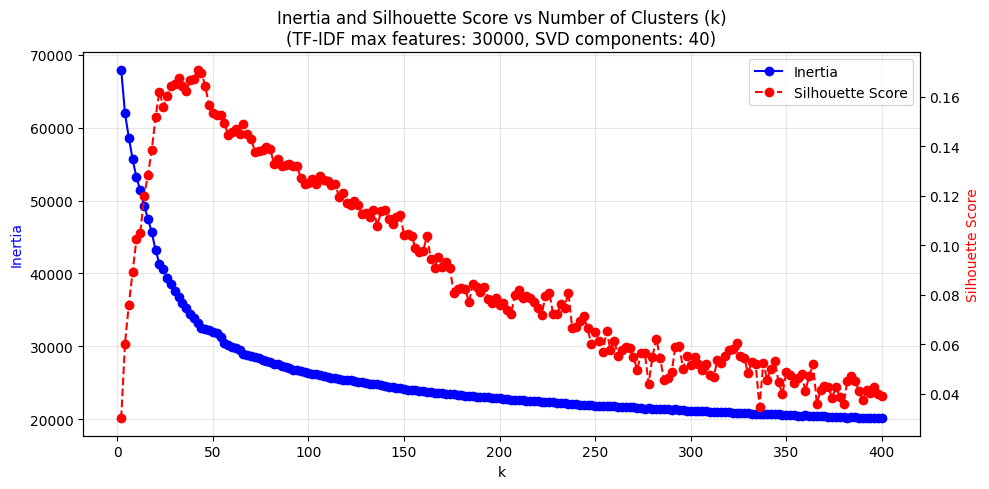

In [40]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=5
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 40
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
df_silhouette_dict[svd_n_components],
tfidf_max_features=tfidf_max_features,
svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 30

In [41]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=5
"""

n_components = 30
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0     26    0.197167  32405.294922
1     22    0.195203  34904.277344
2     30    0.194457  30480.712891
3     28    0.192229  31438.826172
4     36    0.190015  28578.730469
..   ...         ...           ...
195  372    0.032973  17084.330078
196  400    0.032795  16896.566406
197  386    0.032664  16991.039062
198  396    0.032557  16919.042969
199  398    0.029317  16938.876953

[200 rows x 3 columns]

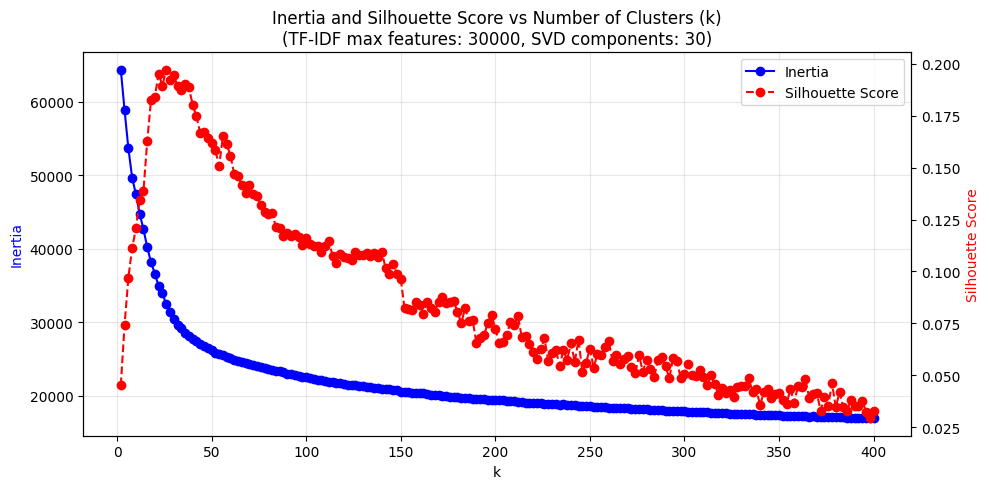

In [42]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=5
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 30
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
df_silhouette_dict[svd_n_components],
tfidf_max_features=tfidf_max_features,
svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 20

In [43]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=5
"""

n_components = 20
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]


k  silhouette       inertia
0     24    0.239586  23883.175781
1     26    0.236488  23176.402344
2     22    0.235516  25140.119141
3     28    0.220213  22729.779297
4     30    0.218081  22262.361328
..   ...         ...           ...
195  364    0.032029  12324.320312
196  376    0.028642  12251.748047
197  400    0.027403  12105.700195
198  398    0.027210  12144.602539
199  390    0.026375  12164.985352

[200 rows x 3 columns]

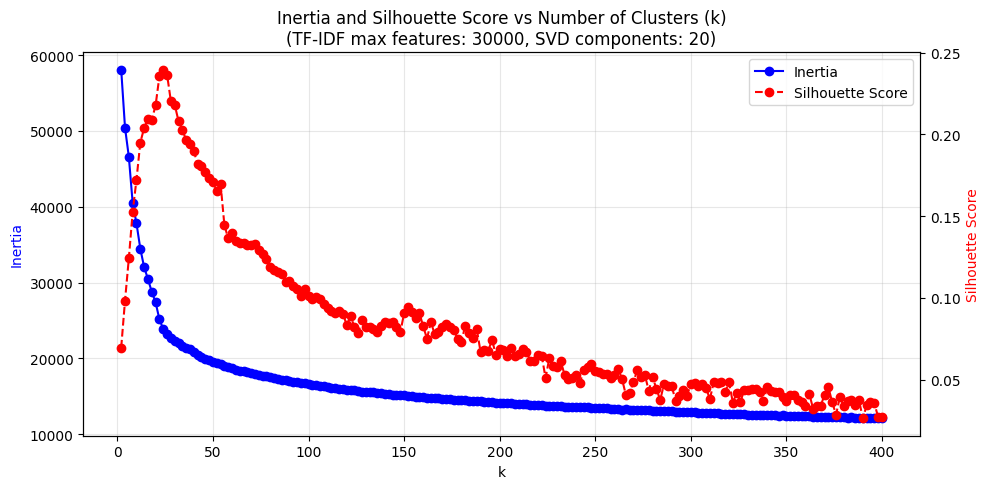

In [44]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=5
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 20
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
df_silhouette_dict[svd_n_components],
tfidf_max_features=tfidf_max_features,
svd_n_components=svd_n_components
)

#### Experiments starting with n_components = 60

In [91]:
"""
Compute (or load from disk) SVD model and X_reduced for n_components=5
"""

n_components = 60
# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
	X_reduced_dict = {}
else:
	X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
	print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
if X_reduced_dict.get(n_components) is None:
	# Create, fit and transform SVD pipeline for n_components
	X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
	# Save the updated dictionary to disk
	joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)

Loaded existing X_reduced_dict with keys n_components: [5, 5000, 500, 100, 50, 40, 30, 20]
SVD Pipeline created with n_components=60
Reduced data shape: (89928, 60)
Explained variance: 0.0925


k  silhouette       inertia
0     86    0.162169  32858.554688
1     58    0.160391  36823.609375
2     54    0.159916  37684.843750
3     52    0.159383  38302.273438
4     68    0.157596  35105.089844
..   ...         ...           ...
195  384    0.047405  24464.568359
196    4    0.047100  67014.093750
197  388    0.045151  24382.218750
198  386    0.044809  24451.472656
199    2    0.019788  72225.234375

[200 rows x 3 columns]

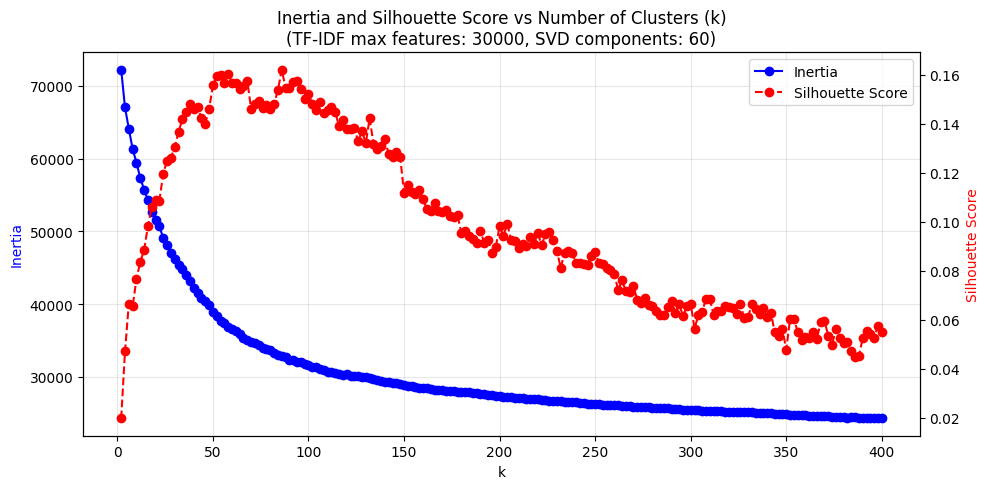

In [92]:
"""
Now evaluate different k values for clustering in the SVD-reduced space with n_components=5
"""

# Define tfidf_max_features and svd_n_components for selecting the X_reduced
tfidf_max_features = 30_000
svd_n_components = 60
# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
    df_silhouette_dict = {}
else:
    df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
    print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
# Define k values to evaluate
k_values = list(range(2, 401, 2))
# Evaluate k values for the selected svd_n_components
df_silhouette_dict[svd_n_components] = evaluate_k(
	k_values,
	X_reduced_dict[svd_n_components],
	df_silhouette_dict.get(svd_n_components, pd.DataFrame())
)
# Save the updated dictionary to disk
joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
# Display silhouette df
display(df_silhouette_dict[svd_n_components])
# Plot silhouette and inertia
plot_silhouette_inertia(
df_silhouette_dict[svd_n_components],
tfidf_max_features=tfidf_max_features,
svd_n_components=svd_n_components
)

## Final K-means model

In [45]:
# Train final K-means model with the selected number of clusters
kmeans = KMeans(
    n_clusters=selected_k,
    init="k-means++",
    n_init="auto",
    random_state=RANDOM_SEED,
)
# Fit K-means and predict cluster labels
cluster_labels = kmeans.fit_predict(X_reduced)

In [46]:
# Assign cluster labels to the original dataframe
df_train["id_topic"] = cluster_labels
df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  id_topic  
0      Singer, activist Joan Baez becomes Kennedy Cen...       177       289  
1      'Nothing but problems': Shipwreck tear-down en...      5332       115  
2      Report: At least 13 dead in Istanbul bombings....       248       253  
3      Senate Republicans Pressure Joe Biden to Withd...      4920        91  
4      The Unwelcome Return of the Real Purveyors of ...      3894        38  
...                                                  ...       ...       ...  
89923  An Interview with Mark Blaxill on the Autism T...      1998       237  
89924  Vietnam reconsiders methane-emitting rice amid...      9005        18  
89925  Shaker furniture: Clean by design. The Hancock...       262        85  
89926  53 pot shop lottery winners announced, includi...      2093       161  
89927  Singer Ani DiFranco on career, new album "Revo...       394       139  

[89928 rows x 6 columns]

# Gridsearch for global hyperparameters tuning

## Helper functions

In [47]:
def calculate_df_silhouettes_from_gridsearch(
	texts: list,
	param_grid: dict,
	df_grid_search: pd.DataFrame = pd.DataFrame(),
	random_seed: int = RANDOM_SEED
) -> pd.DataFrame:
	"""
	Perform GridSearchCV to find best hyperparameters for topic modeling pipeline
	using silhouette score as evaluation metric.
	Args:
		texts (list): List of text documents.
		param_grid (dict): Hyperparameter grid for GridSearchCV.
		df_grid_search (pd.DataFrame): DataFrame to append results to.
		random_seed (int): Random seed for reproducibility.
	Returns:
		pd.DataFrame: DataFrame with silhouette scores for each hyperparameter combination.
	"""
	
	def _silhouette_scorer(estimator, X, y=None):
		# Transform X (tfidf + svd)
		X_emb = estimator[:-1].transform(X)

		# Predict cluster labels on this X
		labels = estimator.named_steps["cluster"].predict(X_emb)

		# Compute silhouette on a smaller sample to speed up
		return silhouette_score(
			X_emb,
			labels,
			metric="euclidean",
			sample_size=min(5000, X_emb.shape[0]),
			random_state=RANDOM_SEED,
		)

	texts = np.asarray(texts, dtype=object)  # assumes you already have `texts`

	SUBSAMPLE_N = min(30000, len(texts))     # adjust if you want
	rng = np.random.default_rng(random_seed)
	idx = rng.choice(len(texts), size=SUBSAMPLE_N, replace=False)
	texts_sub = texts[idx]

	single_split = [(np.arange(len(texts_sub)), np.arange(len(texts_sub)))]

	estimator = Pipeline([
		("tfidf", TfidfVectorizer(
			max_features=30_000,
			min_df=5,
			max_df=0.7,
			ngram_range=(1,2),
			dtype=np.float32,
		)),
		("svd", TruncatedSVD(
			n_components=20,
			random_state=random_seed
		)),
		("cluster", MiniBatchKMeans(
			n_clusters=30,
			n_init=1,
			max_iter=100,
			batch_size=2048,
			random_state=random_seed,
		))
	])

	grid_search = GridSearchCV(
		estimator=estimator,
		param_grid=param_grid,
		scoring=_silhouette_scorer,
		cv=single_split,              # single evaluation split
		n_jobs=-1,
		verbose=2,
		refit=True,
	)
	grid_search.fit(texts_sub)

	print("Best silhouette score:", grid_search.best_score_)
	print("Best params:")
	for k, v in grid_search.best_params_.items():
		print(f"  {k}: {v}")

	df_grid_search = pd.concat(
		[
			df_grid_search,
			pd.DataFrame(grid_search.cv_results_)
		],
		ignore_index=True
	)
	df_grid_search = df_grid_search.sort_values(by="mean_test_score", ascending=False)
	df_grid_search.to_csv(paths.DF_GRID_SEARCH, index=False)

	return df_grid_search

## Experimentation

In [48]:
df_grid_search = pd.DataFrame()

In [49]:
param_grid = {
	"tfidf__max_features": [30_000, 75_000, 125_000],
	# "tfidf__min_df": [3, 5, 10],
	# "tfidf__max_df": [0.7, 0.8, 0.9],
	"svd__n_components": [1_250, 2_500, 5_000],
	"cluster__n_clusters": [200, 300, 425],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=30000; total time= 2.2min
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=75000; total time= 2.8min


KeyboardInterrupt: 

In [ ]:
param_grid = {
	"svd__n_components": [300, 600, 1_000, 1_500, 2_000, 3_000, 4_000, 5_000, 6_000, 8_000],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 800, 900],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"cluster__n_clusters": [30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [25, 50, 75, 100],
	"cluster__n_clusters": [25, 50, 75, 100],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [5, 10, 15, 20],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [30, 50, 100, 200, 300],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15],
	"cluster__n_clusters": [30, 50, 100],
	"tfidf__max_features": [10_000, 20_000, 30_000],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5],
	"cluster__n_clusters": [30],
	"tfidf__max_features": [30_000],
	"tfidf__min_df": [3, 5, 10],
	"tfidf__max_df": [0.6, 0.7, 0.8],
	"tfidf__ngram_range": [(1,1), (1,2), (1,3)],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

## Final model

In [52]:
# Build final pipeline with best hyperparameters found
final_pipeline = Pipeline([
	("tfidf", TfidfVectorizer(
		max_features=TFIDF_BEST_MAX_FEATURES,
		min_df=TFIDF_BEST_MIN_DF,
		max_df=TFIDF_BEST_MAX_DF,
		ngram_range=TFIDF_BEST_NGRAM_RANGE,
		dtype=np.float32,
	)),
	("svd", TruncatedSVD(
		n_components=SVD_BEST_N_COMPONENTS,
		random_state=RANDOM_SEED,
	)),
	("cluster", KMeans(
		n_clusters=KMEANS_BEST_N_CLUSTERS,
		init="k-means++",
		n_init=10,
		random_state=RANDOM_SEED,
	)),
])

# Fit the pipeline on the full dataset (includes TF-IDF, SVD, and K-means)
final_pipeline.fit(texts)

# Get the reduced representation of the full dataset (output of SVD)
X_reduced_final = final_pipeline[:-1].transform(texts)

# Get cluster labels
cluster_labels = final_pipeline.named_steps["cluster"].labels_

# Compute silhouette score on the full dataset
final_silhouette = silhouette_score(X_reduced_final, cluster_labels)
print(f"Final silhouette score on full dataset: {final_silhouette:.4f}")

Final silhouette score on full dataset: 0.1001


In [53]:
# Assign cluster labels to the original dataframe
df_train["id_topic"] = cluster_labels
df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  id_topic  
0      Singer, activist Joan Baez becomes Kennedy Cen...       177         1  
1      'Nothing but problems': Shipwreck tear-down en...      5332        47  
2      Report: At least 13 dead in Istanbul bombings....       248         1  
3      Senate Republicans Pressure Joe Biden to Withd...      4920        13  
4      The Unwelcome Return of the Real Purveyors of ...      3894        18  
...                                                  ...       ...       ...  
89923  An Interview with Mark Blaxill on the Autism T...      1998        45  
89924  Vietnam reconsiders methane-emitting rice amid...      9005        21  
89925  Shaker furniture: Clean by design. The Hancock...       262        25  
89926  53 pot shop lottery winners announced, includi...      2093        47  
89927  Singer Ani DiFranco on career, new album "Revo...       394        25  

[89928 rows x 6 columns]

# Compare configurations - global scorecard

In [ ]:
N_CLUSTERS_GRID = [30, 35, 40, 45, 50]
N_COMPONENTS_GRID = [30, 40, 50, 60, 80, 100]

In [77]:
# ----------------------------
# 0) Utility helpers
# ----------------------------
def safe_z(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    std = x.std(ddof=0)
    if std < 1e-12:
        return np.zeros_like(x)
    return (x - x.mean()) / std


def top_terms_for_cluster(X_tfidf, labels, topic_id, feature_names, n_terms=20):
    idx = np.where(labels == topic_id)[0]
    if len(idx) == 0:
        return []
    X_cluster = X_tfidf[idx]
    tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = tfidf_mean.argsort()[::-1][:n_terms]
    return [feature_names[i] for i in top_idx]

In [78]:
# ----------------------------
# 1) Build df_topics for one config
# ----------------------------
def build_df_topics_for_config(
    X_tfidf,
    X_reduced,
    labels,
    centers,
    feature_names,
    dictionary: Dictionary,
    corpus,
    tokenized_texts,
    n_top_terms=20,
) -> pd.DataFrame:
    k = int(labels.max()) + 1

    # Sizes
    sizes = np.bincount(labels, minlength=k)

    # Distances to centroid (mean per topic)
    dist_centroid = np.zeros(k, dtype=float)
    for t in range(k):
        idx = np.where(labels == t)[0]
        if len(idx) == 0:
            dist_centroid[t] = np.nan
            continue
        d = np.linalg.norm(X_reduced[idx] - centers[t], axis=1)
        dist_centroid[t] = float(d.mean())

    # Topic top terms
    topics_terms = []
    for t in range(k):
        terms = top_terms_for_cluster(
            X_tfidf=X_tfidf,
            labels=labels,
            topic_id=t,
            feature_names=feature_names,
            n_terms=n_top_terms
        )
        # Keep only terms that exist in the Dictionary (defensive)
        terms = [w for w in terms if w in dictionary.token2id]
        topics_terms.append(terms)

    # Coherence per topic (c_npmi and u_mass)
    # c_npmi uses texts + dictionary; u_mass uses corpus + dictionary
    cm_npmi = CoherenceModel(
        topics=topics_terms,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence="c_npmi"
    )
    c_npmi = np.array(cm_npmi.get_coherence_per_topic(), dtype=float)

    cm_umass = CoherenceModel(
        topics=topics_terms,
        corpus=corpus,
        dictionary=dictionary,
        coherence="u_mass"
    )
    u_mass = np.array(cm_umass.get_coherence_per_topic(), dtype=float)

    df = pd.DataFrame({
        "id_topic": np.arange(k),
        "size": sizes,
        "top_terms": topics_terms,
        "c_npmi": c_npmi,
        "u_mass": u_mass,
        "dist_centroid": dist_centroid,
    })

    # Flags based on size percentiles (as you specified)
    p10 = df["size"].quantile(0.10)
    p90 = df["size"].quantile(0.90)
    df["flag_small"] = df["size"] <= p10
    df["flag_big"] = df["size"] >= p90

    # A/B/C buckets (no pctl_* columns persisted; computed internally)
    # We build a simple composite score (higher better):
    # - reward coherence (c_npmi, u_mass)
    # - penalize looseness (dist_centroid)
    # - penalize very small / very big topics a bit
    score = (
        safe_z(df["c_npmi"].values)
        + 0.7 * safe_z(df["u_mass"].values)      # u_mass: higher (less negative) is better
        - 0.7 * safe_z(df["dist_centroid"].values)
        - 0.4 * df["flag_small"].astype(float).values
        - 0.2 * df["flag_big"].astype(float).values
    )
    q1 = np.quantile(score, 1/3)
    q2 = np.quantile(score, 2/3)

    df["quality_bucket"] = np.where(score >= q2, "A",
                             np.where(score >= q1, "B", "C"))

    return df

In [79]:
# ----------------------------
# 2) Summarize df_topics into a global scorecard row
# ----------------------------
def summarize_df_topics(df_topics: pd.DataFrame, n_components: int, n_clusters: int) -> dict:
    # Coherence
    c_npmi = df_topics["c_npmi"].astype(float)
    u_mass = df_topics["u_mass"].astype(float)

    # Geometry
    dist = df_topics["dist_centroid"].astype(float)

    # Size
    size = df_topics["size"].astype(float)

    row = {
        "n_components": n_components,
        "n_clusters": n_clusters,

        # Coherence (robust)
        "c_npmi_mean": float(c_npmi.mean()),
        "c_npmi_median": float(c_npmi.median()),
        "c_npmi_p10": float(c_npmi.quantile(0.10)),

        "u_mass_mean": float(u_mass.mean()),
        "u_mass_median": float(u_mass.median()),
        "u_mass_p10": float(u_mass.quantile(0.10)),  # "floor" (more negative = worse)

        # Geometry
        "dist_mean": float(dist.mean()),
        "dist_median": float(dist.median()),
        "dist_p90": float(dist.quantile(0.90)),      # worst 10%

        # Size distribution
        "size_min": float(size.min()),
        "size_p10": float(size.quantile(0.10)),
        "size_median": float(size.median()),
        "size_p90": float(size.quantile(0.90)),
        "size_max": float(size.max()),

        # Ratios
        "max_over_median": float(size.max() / max(size.median(), 1.0)),
        "median_over_p10": float(size.median() / max(size.quantile(0.10), 1.0)),

        # Flags
        "small_rate": float(df_topics["flag_small"].mean()),
        "big_rate": float(df_topics["flag_big"].mean()),

        # Buckets
        "bucket_A_rate": float((df_topics["quality_bucket"] == "A").mean()),
        "bucket_B_rate": float((df_topics["quality_bucket"] == "B").mean()),
        "bucket_C_rate": float((df_topics["quality_bucket"] == "C").mean()),
    }
    return row

In [115]:
# ----------------------------
# 3) Main evaluation loop (fast: TF-IDF only once)
# ----------------------------
def run_scorecard_grid(
    texts_sub,
    tfidf_params: dict,
    n_components_grid,
    n_clusters_grid,
    n_top_terms=20,
) -> pd.DataFrame:
    # Fit TF-IDF once
    tfidf = TfidfVectorizer(**tfidf_params)
    X_tfidf = tfidf.fit_transform(texts_sub)
    feature_names = tfidf.get_feature_names_out()

    # Tokenize once using the TF-IDF analyzer (critical: consistent with ngrams/stopwords)
    analyzer = tfidf.build_analyzer()
    tokenized_texts = [analyzer(t) for t in texts_sub]

    # Build dictionary/corpus once
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]

    rows = []
    dfs = []

    for n_components in n_components_grid:
        svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)
        print(f"Fitting SVD with n_components={n_components}...")
        X_reduced = svd.fit_transform(X_tfidf)

        for k in n_clusters_grid:
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                random_state=RANDOM_SEED,
                n_init=1,
                max_iter=100,
                batch_size=2048,
            )
            print(f"\tFitting KMeans with n_clusters={k}...")
            labels = kmeans.fit_predict(X_reduced)
            centers = kmeans.cluster_centers_

            df_topics = build_df_topics_for_config(
                X_tfidf=X_tfidf,
                X_reduced=X_reduced,
                labels=labels,
                centers=centers,
                feature_names=feature_names,
                dictionary=dictionary,
                corpus=corpus,
                tokenized_texts=tokenized_texts,
                n_top_terms=n_top_terms,
            )

            row = summarize_df_topics(df_topics, n_components=n_components, n_clusters=k)
            rows.append(row)
            df_topics["n_components"] = n_components
            df_topics["n_clusters"] = k
            df_topics.insert(0, "n_clusters", df_topics.pop("n_clusters"))
            df_topics.insert(0, "n_components", df_topics.pop("n_components"))
            dfs.append(df_topics)
            
    df_scorecards = pd.DataFrame(rows)
    df_all_topics = pd.concat(dfs, ignore_index=True)

    return df_scorecards, df_all_topics

In [81]:
# ----------------------------
# 4) How to rank configs (no composite score; ordered keys)
# ----------------------------
def rank_configs(df_scorecards: pd.DataFrame) -> pd.DataFrame:
    # Priority: raise the "floor" of coherence and reduce bad tails / imbalance.
    # - higher c_npmi_p10 is better
    # - higher u_mass_p10 is better (less negative)
    # - lower dist_p90 is better
    # - lower bucket_C_rate is better
    # - lower max_over_median is better
    return df_scorecards.sort_values(
        by=["c_npmi_p10", "u_mass_p10", "dist_p90", "bucket_C_rate", "max_over_median"],
        ascending=[False, False, True, True, True],
    )


In [82]:
tfidf_params = dict(
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),
    max_features=30_000,
    dtype=np.float32,
    stop_words="english",
)

In [128]:
N_SUB = 20_000
df_sub = df_train.sample(n=min(N_SUB, len(df_train)), random_state=RANDOM_SEED)
texts_sub = df_sub["text"].astype(str).tolist()
len(texts_sub)

20000

In [ ]:
df_scorecards, df_all_topics = run_scorecard_grid(
    texts_sub=texts_sub,  # tu subset fijo
    tfidf_params=tfidf_params,
    n_components_grid=list(range(30, 151, 10)),
    n_clusters_grid=list(range(30, 101, 10)),
    n_top_terms=20,
)
df_scorecards

Fitting SVD with n_components=30...
	Fitting KMeans with n_clusters=30...
	Fitting KMeans with n_clusters=40...
	Fitting KMeans with n_clusters=50...


In [90]:
df_ranked = rank_configs(df_scorecards)
df_ranked

n_components  n_clusters  c_npmi_mean  c_npmi_median  c_npmi_p10  \
15            60          30     0.081811       0.084631    0.012545   
18            60          45     0.071338       0.067251    0.006058   
25           100          30     0.089320       0.091937    0.005173   
17            60          40     0.080939       0.079572    0.005137   
28           100          45     0.083070       0.073213    0.000880   
10            50          30     0.075271       0.066107   -0.004411   
16            60          35     0.068472       0.062272   -0.005121   
5             40          30     0.078373       0.064331   -0.005857   
7             40          40     0.092459       0.082049   -0.008191   
27           100          40     0.072489       0.062034   -0.009932   
12            50          40     0.079538       0.076421   -0.011288   
6             40          35     0.070615       0.063225   -0.016202   
22            80          40     0.069061       0.067771   -0.016313   
24            80          50     0.084704       0.081540   -0.017953   
13            50          45     0.071553       0.078481   -0.018663   
11            50          35     0.076595       0.083280   -0.019981   
19            60          50     0.078913       0.069745   -0.020030   
4             30          50     0.094539       0.091251   -0.020344   
26           100          35     0.064388       0.053582   -0.020882   
20            80          30     0.077909       0.086623   -0.022542   
2             30          40     0.089190       0.094605   -0.022582   
9             40          50     0.084407       0.079335   -0.024605   
8             40          45     0.087975       0.080807   -0.026282   
0             30          30     0.081693       0.081257   -0.026445   
1             30          35     0.080342       0.077970   -0.028096   
21            80          35     0.077678       0.087495   -0.029508   
14            50          50     0.077435       0.079832   -0.031301   
29           100          50     0.071003       0.068219   -0.035311   
3             30          45     0.081226       0.087121   -0.035440   
23            80          45     0.063973       0.059679   -0.043574   

    u_mass_mean  u_mass_median  u_mass_p10  dist_mean  dist_median  ...  \
15    -1.813388      -1.692968   -2.023038   0.237952     0.243039  ...   
18    -1.830400      -1.699185   -2.441364   0.228885     0.225696  ...   
25    -2.006782      -1.786256   -2.811707   0.285519     0.282572  ...   
17    -1.807443      -1.687501   -2.144689   0.228895     0.228947  ...   
28    -1.826713      -1.763492   -2.335643   0.281606     0.273996  ...   
10    -1.809846      -1.650614   -2.155579   0.226815     0.219369  ...   
16    -2.086367      -1.693795   -2.198049   0.237068     0.232177  ...   
5     -1.608765      -1.669610   -1.935295   0.196115     0.202524  ...   
7     -1.702397      -1.659162   -2.067548   0.189756     0.199730  ...   
27    -1.917919      -1.717805   -2.721790   0.278597     0.269943  ...   
12    -1.745675      -1.681316   -2.306216   0.209705     0.213843  ...   
6     -1.662442      -1.587778   -2.043487   0.194206     0.196298  ...   
22    -1.745754      -1.695296   -2.307181   0.258205     0.259480  ...   
24    -1.765610      -1.678133   -2.385210   0.252794     0.244192  ...   
13    -1.788599      -1.679632   -2.249636   0.210760     0.214192  ...   
11    -1.737530      -1.660477   -2.357889   0.217981     0.214890  ...   
19    -1.864827      -1.706555   -2.441581   0.219888     0.221382  ...   
4     -1.687370      -1.652887   -2.058694   0.158157     0.164907  ...   
26    -2.249915      -1.770497   -3.025899   0.287445     0.277350  ...   
20    -1.687756      -1.634151   -1.952468   0.267716     0.276824  ...   
2     -1.728601      -1.676657   -2.073758   0.166820     0.171408  ...   
9     -1.753978      -1.692033   -2.467075   0.182891     0.186781  ...   
8     -1.694005      -1.669501   -2.073491   0

In [96]:
df_ranked.describe()

n_components  n_clusters  c_npmi_mean  c_npmi_median  c_npmi_p10  \
count      30.00000    30.00000    30.000000      30.000000   30.000000   
mean       60.00000    40.00000     0.078543       0.076055   -0.016369   
std        24.21171     7.19195     0.007827       0.010662    0.013756   
min        30.00000    30.00000     0.063973       0.053582   -0.043574   
25%        40.00000    35.00000     0.071787       0.067381   -0.025863   
50%        55.00000    40.00000     0.078643       0.078908   -0.019322   
75%        80.00000    45.00000     0.082755       0.082972   -0.006441   
max       100.00000    50.00000     0.094539       0.094605    0.012545   

       u_mass_mean  u_mass_median  u_mass_p10  dist_mean  dist_median  ...  \
count    30.000000      30.000000   30.000000  30.000000    30.000000  ...   
mean     -1.817502      -1.691243   -2.303498   0.223837     0.224352  ...   
std       0.142145       0.041974    0.275435   0.040095     0.036408  ...   
min      -2.249915      -1.786256   -3.025899   0.158157     0.164907  ...   
25%      -1.856220      -1.703500   -2.441527   0.190869     0.197156  ...   
50%      -1.781063      -1.685593   -2.231917   0.223351     0.220375  ...   
75%      -1.730833      -1.669529   -2.073558   0.257897     0.258019  ...   
max      -1.608765      -1.587778   -1.935295   0.287445     0.282572  ...   

       size_median     size_p90     size_max  max_over_median  \
count    30.000000    30.000000    30.000000        30.000000   
mean    317.750000   840.300000  4584.400000        14.603197   
std      44.507022   177.117835   823.023635         2.783671   
min     253.000000   609.500000  2941.000000         9.722314   
25%     278.250000   710.725000  3968.750000        11.856581   
50%     321.500000   792.000000  4509.000000        15.303455   
75%     344.000000   933.425000  5254.250000        16.895483   
max     428.500000  1227.600000  6387.000000        19.587786   

       median_over_p10  small_rate   big_rate  bucket_A_rate  bucket_B_rate  \
count        30.000000   30.000000  30.000000      30.000000      30.000000   
mean          2.504231    0.106190   0.105820       0.339905       0.325190   
std           0.522611    0.008151   0.008172       0.006384       0.007591   
min           1.481795    0.100000   0.100000       0.333333       0.314286   
25%           2.027394    0.100000   0.100000       0.333333       0.320000   
50%           2.507785    0.100000   0.100000       0.340000       0.325000   
75%           2.884908    0.111111   0.111111       0.342857       0.333333   
max           3.377425    0.133333   0.133333       0.350000       0.333333   

       bucket_C_rate  
count      30.000000  
mean        0.334905  
std         0.006307  
min         0.325000  
25%         0.333333  
50%         0.333333  
75%         0.340000  
max         0.342857  

[8 rows x 23 columns]

In [ ]:
def robust_z_global(x, med, iqr, eps=1e-12):
    return (x - med) / (iqr + eps)

In [ ]:
def compute_global_robust_params(df_all, col):
    med = df_all[col].median()
    q25 = df_all[col].quantile(0.25)
    q75 = df_all[col].quantile(0.75)
    iqr = q75 - q25
    return med, iqr

In [ ]:
# 1) parámetros globales
c_med, c_iqr = compute_global_robust_params(df_all_topics, "c_npmi")
u_med, u_iqr = compute_global_robust_params(df_all_topics, "u_mass")
d_med, d_iqr = compute_global_robust_params(df_all_topics, "dist_centroid")

In [ ]:
# 2) z globales
z_c = robust_z_global(df_all_topics["c_npmi"], c_med, c_iqr)
z_u = robust_z_global(df_all_topics["u_mass"], u_med, u_iqr)  # higher is better (menos negativo)
z_d = robust_z_global(df_all_topics["dist_centroid"], d_med, d_iqr)  # higher is worse

In [ ]:
# 3) score global
df_all_topics["score_global"] = (
    z_c
    + 0.7 * z_u
    - 0.7 * z_d
    - 0.4 * df_all_topics["flag_small"].astype(float)
    - 0.2 * df_all_topics["flag_big"].astype(float)
)

In [ ]:
q1 = df_all_topics["score_global"].quantile(1/3)
q2 = df_all_topics["score_global"].quantile(2/3)

df_all_topics["quality_bucket"] = np.where(
    df_all_topics["score_global"] >= q2, "A",
    np.where(df_all_topics["score_global"] >= q1, "B", "C")
)

In [ ]:
df_scorecard = (
    df_all_topics
    .groupby(["n_components", "n_clusters"])
    .agg(
        c_npmi_mean=("c_npmi", "mean"),
        u_mass_mean=("u_mass", "mean"),
        dist_mean=("dist_centroid", "mean"),
        score_mean=("score_global", "mean"),
        bucket_A_rate=("quality_bucket", lambda s: (s=="A").mean()),
        bucket_B_rate=("quality_bucket", lambda s: (s=="B").mean()),
        bucket_C_rate=("quality_bucket", lambda s: (s=="C").mean()),
    )
    .reset_index()
    .sort_values(["bucket_A_rate", "score_mean"], ascending=False)
)
df_scorecard

n_components  n_clusters  c_npmi_mean  u_mass_mean  dist_mean  score_mean  \
1             30          35    -0.066256    -3.538248   0.228565    0.243683   
3             30          45    -0.080508    -4.059461   0.215993    0.077277   
6             40          35    -0.041721    -2.951347   0.263866    0.310272   
2             30          40    -0.072943    -3.953820   0.220058    0.140292   
0             30          30    -0.055960    -3.326589   0.233627    0.350940   
4             30          50    -0.089378    -3.998795   0.208789    0.072621   
5             40          30    -0.048975    -3.030523   0.273612    0.221471   
7             40          40    -0.054048    -3.305438   0.258448    0.210653   
12            50          40    -0.048179    -3.216312   0.290587    0.070214   
9             40          50    -0.071583    -3.673169   0.243766    0.079776   
8             40          45    -0.071994    -3.631629   0.252173   -0.000139   
11            50          35    -0.052220    -3.006764   0.294502    0.014389   
10            50          30    -0.059991    -3.191665   0.301924   -0.098088   
14            50          50    -0.057337    -3.581193   0.274701    0.010397   
17            60          40    -0.060721    -3.355288   0.311454   -0.193722   
16            60          35    -0.058824    -3.431676   0.319382   -0.258874   
13            50          45    -0.066254    -3.736149   0.282162   -0.150806   
15            60          30    -0.051853    -2.867490   0.326707   -0.153718   
20            80          30    -0.052536    -2.960059   0.374452   -0.437091   
22            80          40    -0.051314    -3.552046   0.352665   -0.449733   
18            60          45    -0.070669    -3.932139   0.304836   -0.380356   
23            80          45    -0.060248    -3.788639   0.348113   -0.544617   
21            80          35    -0.057079    -3.589940   0.365975   -0.592621   
19            60          50    -0.080939    -4.161553   0.301482   -0.487760   
24            80          50    -0.061466    -3.715076   0.339805   -0.490571   
28           100          45    -0.081569    -4.094112   0.379451   -1.028883   
27           100          40    -0.078512    -3.973346   0.392292   -1.016667   
26           100          35    -0.057374    -3.393840   0.403145   -0.784031   
29           100          50    -0.081432    -4.095345   0.377243   -0.962831   
25           100          30    -0.047686    -3.071238   0.411915   -0.684302   

    bucket_A_rate  bucket_B_rate  bucket_C_rate  
1        0.514286       0.285714       0.200000  
3        0.488889       0.222222       0.288889  
6        0.485714       0.371429       0.142857  
2        0.475000       0.250000       0.275000  
0        0.466667       0.366667       0.166667  
4        0.460000       0.280000       0.260000  
5        0.433333       0.366667       0.200000  
7        0.425000       0.400000       0.175000  
12       0.400000       0.375000       0.225000  
9        0.380000       0.420000       0.200000  
8        0.377778       0.333333       0.288889  
11       0.371429       0.371429       0.257143  
10       0.366667       0.366667       0.266667  
14       0.360000       0.360000       0.280000  
17       0.325000       0.400000       0.275000  
16       0.314286       0.342857       0.342857  
13       0.311111       0.377778       0.311111  
15       0.300000       0.400000       0.300000  
20       0.300000       0.333333       0.366667  
22       0.300000       0.325000       0.375000  
18       0.288889       0.355556       0.355556  
23       0.288889       0.288889       0.422222  
21       0.285714       0.314286       0.400000  
19       0.260000       0.400000       0.340000  
24       0.260000       0.300000       0.440000  
28       0.177778       0.222222       0.600000  
27       0.175000       0.250000       0.575000  
26       0.171429       0.314286       0.514286  
29       0.160000       0.300000       0.5

# Add distance to centroid metric

In [54]:
# Get centroids
centroids = final_pipeline.named_steps["cluster"].cluster_centers_
centroids.shape  # (n_clusters, n_components)

(50, 50)

In [55]:
# Calculate distances to centroids
distances = LA.norm(X_reduced_final - centroids[cluster_labels], axis=1)
distances.shape

(89928,)

In [56]:
# Add distance to centroid metric to df_train
df_train["dist_centroid"] = distances
df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  id_topic  \
0      Singer, activist Joan Baez becomes Kennedy Cen...       177         1   
1      'Nothing but problems': Shipwreck tear-down en...      5332        47   
2      Report: At least 13 dead in Istanbul bombings....       248         1   
3      Senate Republicans Pressure Joe Biden to Withd...      4920        13   
4      The Unwelcome Return of the Real Purveyors of ...      3894        18   
...                                                  ...       ...       ...   
89923  An Interview with Mark Blaxill on the Autism T...      1998        45   
89924  Vietnam reconsiders methane-emitting rice amid...      9005        21   
89925  Shaker furniture: Clean by design. The Hancock...       262        25   
89926  53 pot shop lottery winners announced, includi...      2093        47   
89927  Singer Ani DiFranco on career, new album "Revo...       394        25   

       dist_centroid  
0           0.106435  
1           0.130480  
2           0.160323  
3           0.174631  
4           0.289562  
...              ...  
89923       0.214257  
89924       0.207092  
89925       0.081143  
89926       0.151272  
89927       0.188471  

[89928 rows x 7 columns]

In [57]:
"""Compute z-score of distance to centroid within each cluster."""

# Compute per-cluster mean and std, then z-score per row
g = df_train.groupby("id_topic")["dist_centroid"]
df_train["dist_mean"] = g.transform("mean")
df_train["dist_std"]  = g.transform("std")  # sample std (ddof=1)

# Avoid division by zero when a cluster has std=0 (all distances identical)
df_train["dist_centroid_z_score"] = np.where(
	df_train["dist_std"] > 0,
	(df_train["dist_centroid"] - df_train["dist_mean"]) / df_train["dist_std"],
	0.0
)

# Remove intermediate columns
df_train.drop(columns=["dist_mean", "dist_std"], inplace=True)

df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  id_topic  \
0      Singer, activist Joan Baez becomes Kennedy Cen...       177         1   
1      'Nothing but problems': Shipwreck tear-down en...      5332        47   
2      Report: At least 13 dead in Istanbul bombings....       248         1   
3      Senate Republicans Pressure Joe Biden to Withd...      4920        13   
4      The Unwelcome Return of the Real Purveyors of ...      3894        18   
...                                                  ...       ...       ...   
89923  An Interview with Mark Blaxill on the Autism T...      1998        45   
89924  Vietnam reconsiders methane-emitting rice amid...      9005        21   
89925  Shaker furniture: Clean by design. The Hancock...       262        25   
89926  53 pot shop lottery winners announced, includi...      2093        47   
89927  Singer Ani DiFranco on career, new album "Revo...       394        25   

       dist_centroid  dist_centroid_z_score  
0           0.106435              -1.196037  
1           0.130480              -1.266217  
2           0.160323              -0.398593  
3           0.174631              -0.738630  
4           0.289562               1.292225  
...              ...                    ...  
89923       0.214257               0.740596  
89924       0.207092              -0.092431  
89925       0.081143              -1.412687  
89926       0.151272              -0.785363  
89927       0.188471               1.041672  

[89928 rows x 8 columns]

# Add topics coherence metrics

In [59]:
# ----------------------------
# 1) Tokenización consistente con TF-IDF (incluye n-grams)
# ----------------------------
analyzer = tfidf.build_analyzer()
vocab_set = set(tfidf.get_feature_names_out())

# Tokens por documento, filtrados a vocabulario TF-IDF
texts_tokens = []
for doc in texts:
    toks = analyzer(doc)
    toks = [t for t in toks if t in vocab_set]   # importante: mantiene unigramas+bigrams del vectorizer
    texts_tokens.append(toks)

# Gensim dictionary + corpus (para u_mass)
dictionary = Dictionary(texts_tokens)
corpus = [dictionary.doc2bow(toks) for toks in texts_tokens]

In [60]:
# ----------------------------
# 2) Top-N terms por cluster/topic (tu función, pero con feature_names explícito)
# ----------------------------
feature_names = tfidf.get_feature_names_out()

def top_terms_for_cluster(X_tfidf, labels, id_topic, feature_names, n_terms=20):
    idx = np.where(labels == id_topic)[0]
    X_cluster = X_tfidf[idx]
    tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
    top_idx = tfidf_mean.argsort()[::-1][:n_terms]
    return [feature_names[i] for i in top_idx]

topic_ids = np.unique(cluster_labels)
topics = [
    top_terms_for_cluster(X_tfidf, cluster_labels, int(tid), feature_names, n_terms=20)
    for tid in topic_ids
]

In [61]:
# ----------------------------
# 3) Coherence: c_npmi y u_mass (por topic)
# ----------------------------
cm_npmi = CoherenceModel(
    topics=topics,
    texts=texts_tokens,
    dictionary=dictionary,
    coherence="c_npmi"
)
npmi_per_topic = cm_npmi.get_coherence_per_topic()
npmi_global = cm_npmi.get_coherence()

cm_umass = CoherenceModel(
    topics=topics,
    corpus=corpus,
    dictionary=dictionary,
    coherence="u_mass"
)
umass_per_topic = cm_umass.get_coherence_per_topic()
umass_global = cm_umass.get_coherence()

print("Global c_npmi:", npmi_global)
print("Global u_mass:", umass_global)

Global c_npmi: 0.10229367481885594
Global u_mass: -1.6247732421228336


In [67]:
# ----------------------------
# 4) DataFrame auditable por topic
# ----------------------------
topic_sizes = pd.Series(cluster_labels).value_counts().to_dict()

df_topics = pd.DataFrame({
    "id_topic": [int(tid) for tid in topic_ids],
    "size": [int(topic_sizes.get(int(tid), 0)) for tid in topic_ids],
    "top_terms": [" | ".join(t) for t in topics],
    "c_npmi": npmi_per_topic,
    "u_mass": umass_per_topic,
}).sort_values(["c_npmi", "size"], ascending=[False, False]).reset_index(drop=True)

df_topics

id_topic   size                                          top_terms  \
0         11    162  visit mobile | reading page | need visit | ver...   
1         33    269  cbs evening | evening news | evening | cbs | h...   
2         44    833  league | villa | premier league | premier | se...   
3         15   1421  senate | democrats | house | biden | republica...   
4         28    667  israel | israeli | gaza | hamas | palestinian ...   
5         41   1602  election | voting | state | voters | republica...   
6         40    539  taliban | afghanistan | afghan | kabul | biden...   
7         29    877  afghanistan | taliban | afghan | kabul | airpo...   
8          3    651  floyd | rittenhouse | chauvin | trial | george...   
9         27   1530  vaccine | covid | vaccines | doses | covid 19 ...   
10        19   1032  covid | covid 19 | 19 | cases | variant | heal...   
11        12    896  court | supreme court | supreme | abortion | l...   
12         5    802  tax | stimulus | payments | unemployment | inc...   
13        21   1260  climate | climate change | change | emissions ...   
14         6   1059  border | migrants | biden | border patrol | me...   
15         2   1850  game | england | team | players | games | win ...   
16        42    427  cuomo | york | new york | governor | andrew cu...   
17        38   2364  police | man | shooting | said | year old | ol...   
18        20    745  police said | police | chicago | man | shot | ...   
19        39    528  cent | uk | year | ftse | london | said | mark...   
20         9   1224  capitol | trump | police | riot | capitol poli...   
21        32   1108  people | think | know | going | just | said | ...   
22        31    832  share | share pinterest | facebook share | sha...   
23        17   1747  uk | eu | government | covid | johnson | said ...   
24        23   2131  said | court | attorney | prison | prosecutors...   
25        34    744  iran | nuclear | korea | north korea | north |...   
26        24   1137  china | chinese | hong | beijing | kong | hong...   
27        48   1242  vaccinated | mask | vaccine | covid | said | m...   
28        14   2213  trump | president | election | donald | house ...   
29         4    993  school | students | schools | parents | teache...   
30         1   2926  cbs | cbs news | joins | news | cbsn | discuss...   
31        45   2194  people | know | like | just | want | need | do...   
32        36   2674  covid | covid 19 | 19 | cases | illinois | new...   
33        10   1320  said | water | storm | weather | people | cali...   
34        30   4372  people | said | covid | going | think | know |...   
35        26   1136  gun | gun control | guns | control | firearms ...   
36         7    925  university | students | campus | student | cam...   
37        49   1454  trump | donald | donald trump | president | pr...   
38        22   1643  said | just | like | time | people | did | fam...   
39        43   1355  police | officers | officer | said | shooting ...   
40        47   3440  said | company | year | new | bitcoin | market...   
41        16   3178  said | mr | man | prince | email | family | sa...   
42         8    592  arbitration | today | moon | feel | make | wan...   
43        35   2490  people | like | just | said | new | world | tr...   
44        13   2638  said | woman | family | told | like | just | m...   
45         0   2153  biden | president | white house | white | hous...   
46        25  17059  new | reports | says | people | said | year | ...   
47        18    957  activist post | activist | peace freedom | fre...   
48        37   4179  said | people | state | president | actor | go...   
49        46    358  christie | report | gloria christie | gloria |...   

      c_npmi    u_mass  
0   0.554967 -0.082368  
1   0.316243 -2.327382  
2   0.199067 -1.365065  
3   0.172565 -1.613508  
4   0.162297 -1.575230  
5   0.153672 -1.442480  
6   0.153222 -1.428656  
7   0.151623 -1.698132  
8   

## Add centroids information to df_topics

In [65]:
df_centroids = df_train.groupby("id_topic")["dist_centroid"].mean().reset_index()
df_centroids

id_topic  dist_centroid
0          0       0.237632
1          1       0.187258
2          2       0.182558
3          3       0.249401
4          4       0.227028
5          5       0.231385
6          6       0.223194
7          7       0.193719
8          8       0.207687
9          9       0.229518
10        10       0.192260
11        11       0.085477
12        12       0.238338
13        13       0.215777
14        14       0.241326
15        15       0.233318
16        16       0.164567
17        17       0.187654
18        18       0.214534
19        19       0.258546
20        20       0.184391
21        21       0.212083
22        22       0.218462
23        23       0.188771
24        24       0.217962
25        25       0.142919
26        26       0.223358
27        27       0.232857
28        28       0.205715
29        29       0.176168
30        30       0.160867
31        31       0.186207
32        32       0.254072
33        33       0.279212
34        34       0.228671
35        35       0.235036
36        36       0.201088
37        37       0.210270
38        38       0.171381
39        39       0.201958
40        40       0.225604
41        41       0.225180
42        42       0.238559
43        43       0.219911
44        44       0.182705
45        45       0.181977
46        46       0.238120
47        47       0.185229
48        48       0.239241
49        49       0.185553

In [68]:
df_topics = df_topics.merge(
	df_centroids,
	on="id_topic",
	how="left",
)
df_topics

id_topic   size                                          top_terms  \
0         11    162  visit mobile | reading page | need visit | ver...   
1         33    269  cbs evening | evening news | evening | cbs | h...   
2         44    833  league | villa | premier league | premier | se...   
3         15   1421  senate | democrats | house | biden | republica...   
4         28    667  israel | israeli | gaza | hamas | palestinian ...   
5         41   1602  election | voting | state | voters | republica...   
6         40    539  taliban | afghanistan | afghan | kabul | biden...   
7         29    877  afghanistan | taliban | afghan | kabul | airpo...   
8          3    651  floyd | rittenhouse | chauvin | trial | george...   
9         27   1530  vaccine | covid | vaccines | doses | covid 19 ...   
10        19   1032  covid | covid 19 | 19 | cases | variant | heal...   
11        12    896  court | supreme court | supreme | abortion | l...   
12         5    802  tax | stimulus | payments | unemployment | inc...   
13        21   1260  climate | climate change | change | emissions ...   
14         6   1059  border | migrants | biden | border patrol | me...   
15         2   1850  game | england | team | players | games | win ...   
16        42    427  cuomo | york | new york | governor | andrew cu...   
17        38   2364  police | man | shooting | said | year old | ol...   
18        20    745  police said | police | chicago | man | shot | ...   
19        39    528  cent | uk | year | ftse | london | said | mark...   
20         9   1224  capitol | trump | police | riot | capitol poli...   
21        32   1108  people | think | know | going | just | said | ...   
22        31    832  share | share pinterest | facebook share | sha...   
23        17   1747  uk | eu | government | covid | johnson | said ...   
24        23   2131  said | court | attorney | prison | prosecutors...   
25        34    744  iran | nuclear | korea | north korea | north |...   
26        24   1137  china | chinese | hong | beijing | kong | hong...   
27        48   1242  vaccinated | mask | vaccine | covid | said | m...   
28        14   2213  trump | president | election | donald | house ...   
29         4    993  school | students | schools | parents | teache...   
30         1   2926  cbs | cbs news | joins | news | cbsn | discuss...   
31        45   2194  people | know | like | just | want | need | do...   
32        36   2674  covid | covid 19 | 19 | cases | illinois | new...   
33        10   1320  said | water | storm | weather | people | cali...   
34        30   4372  people | said | covid | going | think | know |...   
35        26   1136  gun | gun control | guns | control | firearms ...   
36         7    925  university | students | campus | student | cam...   
37        49   1454  trump | donald | donald trump | president | pr...   
38        22   1643  said | just | like | time | people | did | fam...   
39        43   1355  police | officers | officer | said | shooting ...   
40        47   3440  said | company | year | new | bitcoin | market...   
41        16   3178  said | mr | man | prince | email | family | sa...   
42         8    592  arbitration | today | moon | feel | make | wan...   
43        35   2490  people | like | just | said | new | world | tr...   
44        13   2638  said | woman | family | told | like | just | m...   
45         0   2153  biden | president | white house | white | hous...   
46        25  17059  new | reports | says | people | said | year | ...   
47        18    957  activist post | activist | peace freedom | fre...   
48        37   4179  said | people | state | president | actor | go...   
49        46    358  christie | report | gloria christie | gloria |...   

      c_npmi    u_mass  dist_centroid  
0   0.554967 -0.082368       0.085477  
1   0.316243 -2.327382       0.279212  
2   0.199067 -1.365065       0.182705  
3   0.172565 -1.613508       0.233318  
4   0.162297 -1.575230       

In [69]:
df_topics.describe()

id_topic          size     c_npmi     u_mass  dist_centroid
count  50.00000     50.000000  50.000000  50.000000      50.000000
mean   24.50000   1798.560000   0.102294  -1.624773       0.209094
std    14.57738   2404.124748   0.090418   0.427694       0.033181
min     0.00000    162.000000  -0.077876  -2.442704       0.085477
25%    12.25000    832.250000   0.055624  -1.842737       0.186470
50%    24.50000   1233.000000   0.095906  -1.620830       0.215156
75%    36.75000   2147.500000   0.129852  -1.431971       0.232489
max    49.00000  17059.000000   0.554967  -0.082368       0.279212

In [ ]:
def add_topic_quality_columns(df_topics: pd.DataFrame) -> pd.DataFrame:
    df = df_topics.copy()

    # ---------- Percentile ranks (0..1) ----------
    # Higher is better for these:
    df["pctl_c_npmi"] = df["c_npmi"].rank(pct=True)
    df["pctl_u_mass"] = df["u_mass"].rank(pct=True)  # (menos negativo => rank mayor)

    # Lower is better for dist_centroid => invertimos
    df["pctl_dist_tight"] = 1.0 - df["dist_centroid"].rank(pct=True)

    # Size: percentil "natural" (sirve para detectar extremos)
    df["pctl_size"] = df["size"].rank(pct=True)

    # ---------- Z-scores (orientados: más alto = mejor) ----------
    def zscore(s: pd.Series) -> pd.Series:
        std = s.std(ddof=0)
        return (s - s.mean()) / (std if std > 0 else 1.0)

    df["z_c_npmi"] = zscore(df["c_npmi"])
    df["z_u_mass"] = zscore(df["u_mass"])
    df["z_dist_tight"] = zscore(-df["dist_centroid"])  # invertimos: más tight => mejor

    # ---------- Quantile thresholds for flags ----------
    q = df[["c_npmi", "u_mass", "dist_centroid", "size"]].quantile([0.10, 0.25, 0.75, 0.90])

    c_p25, c_p75 = q.loc[0.25, "c_npmi"], q.loc[0.75, "c_npmi"]
    u_p25, u_p75 = q.loc[0.25, "u_mass"], q.loc[0.75, "u_mass"]
    d_p25, d_p75 = q.loc[0.25, "dist_centroid"], q.loc[0.75, "dist_centroid"]
    s_p10, s_p90 = q.loc[0.10, "size"], q.loc[0.90, "size"]

    # ---------- Flags ----------
    df["flag_good_coherence"] = (df["c_npmi"] >= c_p75) & (df["u_mass"] >= u_p75)
    df["flag_poor_coherence"] = (df["c_npmi"] <= c_p25) & (df["u_mass"] <= u_p25)

    df["flag_tight"] = df["dist_centroid"] <= d_p25
    df["flag_loose"] = df["dist_centroid"] >= d_p75

    df["flag_small"] = df["size"] <= s_p10
    df["flag_big"] = df["size"] >= s_p90

    # Un flag de auditoría simple (lo que revisarías primero)
    df["flag_review"] = (
        df["flag_poor_coherence"] |
        df["flag_loose"] |
        df["flag_small"] |
        df["flag_big"]
    )

    # ---------- Bucket simple (A/B/C) ----------
    # Ajusta la lógica si quieres ser más estricto.
    df["quality_bucket"] = np.select(
        [
            df["flag_good_coherence"] & df["flag_tight"] & ~df["flag_small"],
            (~df["flag_poor_coherence"]) & (~df["flag_loose"]) & (df["pctl_c_npmi"] >= 0.50) & (df["pctl_u_mass"] >= 0.50),
        ],
        ["A", "B"],
        default="C",
    )

    return df

In [72]:
df_topics = add_topic_quality_columns(df_topics)
df_topics

id_topic   size                                          top_terms  \
0         11    162  visit mobile | reading page | need visit | ver...   
1         33    269  cbs evening | evening news | evening | cbs | h...   
2         44    833  league | villa | premier league | premier | se...   
3         15   1421  senate | democrats | house | biden | republica...   
4         28    667  israel | israeli | gaza | hamas | palestinian ...   
5         41   1602  election | voting | state | voters | republica...   
6         40    539  taliban | afghanistan | afghan | kabul | biden...   
7         29    877  afghanistan | taliban | afghan | kabul | airpo...   
8          3    651  floyd | rittenhouse | chauvin | trial | george...   
9         27   1530  vaccine | covid | vaccines | doses | covid 19 ...   
10        19   1032  covid | covid 19 | 19 | cases | variant | heal...   
11        12    896  court | supreme court | supreme | abortion | l...   
12         5    802  tax | stimulus | payments | unemployment | inc...   
13        21   1260  climate | climate change | change | emissions ...   
14         6   1059  border | migrants | biden | border patrol | me...   
15         2   1850  game | england | team | players | games | win ...   
16        42    427  cuomo | york | new york | governor | andrew cu...   
17        38   2364  police | man | shooting | said | year old | ol...   
18        20    745  police said | police | chicago | man | shot | ...   
19        39    528  cent | uk | year | ftse | london | said | mark...   
20         9   1224  capitol | trump | police | riot | capitol poli...   
21        32   1108  people | think | know | going | just | said | ...   
22        31    832  share | share pinterest | facebook share | sha...   
23        17   1747  uk | eu | government | covid | johnson | said ...   
24        23   2131  said | court | attorney | prison | prosecutors...   
25        34    744  iran | nuclear | korea | north korea | north |...   
26        24   1137  china | chinese | hong | beijing | kong | hong...   
27        48   1242  vaccinated | mask | vaccine | covid | said | m...   
28        14   2213  trump | president | election | donald | house ...   
29         4    993  school | students | schools | parents | teache...   
30         1   2926  cbs | cbs news | joins | news | cbsn | discuss...   
31        45   2194  people | know | like | just | want | need | do...   
32        36   2674  covid | covid 19 | 19 | cases | illinois | new...   
33        10   1320  said | water | storm | weather | people | cali...   
34        30   4372  people | said | covid | going | think | know |...   
35        26   1136  gun | gun control | guns | control | firearms ...   
36         7    925  university | students | campus | student | cam...   
37        49   1454  trump | donald | donald trump | president | pr...   
38        22   1643  said | just | like | time | people | did | fam...   
39        43   1355  police | officers | officer | said | shooting ...   
40        47   3440  said | company | year | new | bitcoin | market...   
41        16   3178  said | mr | man | prince | email | family | sa...   
42         8    592  arbitration | today | moon | feel | make | wan...   
43        35   2490  people | like | just | said | new | world | tr...   
44        13   2638  said | woman | family | told | like | just | m...   
45         0   2153  biden | president | white house | white | hous...   
46        25  17059  new | reports | says | people | said | year | ...   
47        18    957  activist post | activist | peace freedom | fre...   
48        37   4179  said | people | state | president | actor | go...   
49        46    358  christie | report | gloria christie | gloria |...   

      c_npmi    u_mass  dist_centroid  pctl_c_npmi  pctl_u_mass  \
0   0.554967 -0.082368       0.085477         1.00         1.00   
1   0.316243 -2.327382       0.279212         0.98         0.04   
2   0.199067 -1.365065      

In [74]:
# Ejemplo de auditoría rápida:
df_review = df_topics[df_topics["flag_review"]].sort_values(
    ["flag_poor_coherence", "flag_loose", "flag_small", "flag_big", "pctl_c_npmi"],
    ascending=[False, False, False, False, True]
)
df_review

id_topic   size                                          top_terms  \
46        25  17059  new | reports | says | people | said | year | ...   
41        16   3178  said | mr | man | prince | email | family | sa...   
40        47   3440  said | company | year | new | bitcoin | market...   
37        49   1454  trump | donald | donald trump | president | pr...   
49        46    358  christie | report | gloria christie | gloria |...   
16        42    427  cuomo | york | new york | governor | andrew cu...   
1         33    269  cbs evening | evening news | evening | cbs | h...   
45         0   2153  biden | president | white house | white | hous...   
43        35   2490  people | like | just | said | new | world | tr...   
28        14   2213  trump | president | election | donald | house ...   
27        48   1242  vaccinated | mask | vaccine | covid | said | m...   
21        32   1108  people | think | know | going | just | said | ...   
11        12    896  court | supreme court | supreme | abortion | l...   
10        19   1032  covid | covid 19 | 19 | cases | variant | heal...   
9         27   1530  vaccine | covid | vaccines | doses | covid 19 ...   
8          3    651  floyd | rittenhouse | chauvin | trial | george...   
3         15   1421  senate | democrats | house | biden | republica...   
19        39    528  cent | uk | year | ftse | london | said | mark...   
0         11    162  visit mobile | reading page | need visit | ver...   
48        37   4179  said | people | state | president | actor | go...   
34        30   4372  people | said | covid | going | think | know |...   

      c_npmi    u_mass  dist_centroid  pctl_c_npmi  pctl_u_mass  \
46 -0.002289 -1.925477       0.142919         0.08         0.22   
41  0.027837 -2.059785       0.164567         0.18         0.16   
40  0.036963 -1.927812       0.185229         0.20         0.20   
37  0.049366 -2.305770       0.185553         0.26         0.06   
49 -0.077876 -0.899023       0.238120         0.02         0.96   
16  0.120098 -1.868452       0.238559         0.68         0.24   
1   0.316243 -2.327382       0.279212         0.98         0.04   
45  0.019765 -1.835839       0.237632         0.10         0.28   
43  0.024829 -1.244919       0.235036         0.14         0.92   
28  0.091943 -1.403590       0.241326         0.44         0.80   
27  0.093017 -1.538800       0.239241         0.46         0.66   
21  0.103151 -1.456580       0.254072         0.58         0.70   
11  0.133070 -1.606229       0.238338         0.78         0.56   
10  0.136652 -1.552531       0.258546         0.80         0.64   
9   0.142290 -1.595654       0.232857         0.82         0.58   
8   0.150706 -1.712351       0.249401         0.84         0.38   
3   0.172565 -1.613508       0.233318         0.94         0.54   
19  0.109536 -2.288030       0.201958         0.62         0.08   
0   0.554967 -0.082368       0.085477         1.00         1.00   
48 -0.004302 -1.663723       0.210270         0.04         0.46   
34  0.075821 -1.207245       0.160867         0.32         0.94   

    pctl_dist_tight  pctl_size  ...  z_u_mass  z_dist_tight  \
46             0.96       1.00  ... -0.710221      2.014589   
41             0.92       0.92  ... -1.027436      1.355553   
40             0.78       0.94  ... -0.715735      0.726528   
37             0.76       0.62  ... -1.608418      0.716666   
49             0.16       0.06  ...  1.714118     -0.883655   
16             0.12       0.08  ... -0.575534     -0.897022   
1              0.00       0.04  ... -1.659463     -2.134633   
45             0.18       0.76  ... -0.498508     -0.868782   
43             0.20       0.84  ...  0.897161     -0.789755   
28             0.08       0.80  ...  0.522404     -0.981251   
27             0.10       0.52  ...  0.203056     -0.917768   
21             0.04       0.44  ...  0.397249     -1.369265   
11             0.14       0.32  ...  0.043800     -0.890268   
10             0.0

In [75]:
df_topics.columns

Index(['id_topic', 'size', 'top_terms', 'c_npmi', 'u_mass', 'dist_centroid',
       'pctl_c_npmi', 'pctl_u_mass', 'pctl_dist_tight', 'pctl_size',
       'z_c_npmi', 'z_u_mass', 'z_dist_tight', 'flag_good_coherence',
       'flag_poor_coherence', 'flag_tight', 'flag_loose', 'flag_small',
       'flag_big', 'flag_review', 'quality_bucket'],
      dtype='object')

# Inspect topics

In [62]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [ ]:
def show_cluster_examples(df, id_topic, n=5):
	"""
	Show n example titles from the given cluster_id.
	"""
	subset = df[df["id_topic"] == id_topic].sample(n, random_state=RANDOM_SEED)
	for i, row in subset.iterrows():
		print(f"- {row['title']}")

In [ ]:
def top_terms_for_cluster(X_tfidf, labels, id_topic, n_terms=50):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	idx = np.where(labels == id_topic)[0]
	X_cluster = X_tfidf[idx]
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [ ]:
def bot_terms_for_cluster(X_tfidf, feature_names, n_terms=15):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::][:n_terms]
	return [feature_names[i] for i in top_idx]

In [ ]:
def top_terms_for_cluster(X_tfidf, feature_names, n_terms=15):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		labels (array-like): Cluster labels for each document.
		topic_id (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_tfidf.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [ ]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(30), 5):
	print(f"\n=== CLUSTER {c} ===")
	print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
	show_cluster_examples(df_train, c, n=5)


=== CLUSTER 18 ===
['biden', 'president', 'said', 'state', 'administration', 'house', 'trump', 'senate', 'democrats', 'border', 'election', 'federal', 'states', 'law', 'new', 'joe', 'republicans', 'court', 'voting', 'republican', 'joe biden', 'texas', 'biden administration', 'percent', 'vote', 'voters', 'american', 'news', 'immigration', 'white', 'americans', 'government', 'support', 'department', 'rights', 'united', 'legislation', 'democratic', 'white house', 'illegal', 'people', 'breitbart', 'president joe', 'united states', 'act', 'party', 'plan', 'policy', '000', 'secretary']
- Ron DeSantis Notified Of Federal Action Over Discrimination
- State Department: Labeling Houthis Terrorists Blocked Aid to Yemen
- How to fight back against Republican efforts to 'overthrow legitimate election results': columnist
- Israeli PM denounces Iran, ignores Palestinians in UN speech
- Senate Democrats move immediately to "Plan B" on minimum wage

=== CLUSTER 25 ===
['biden', 'democrats', 'president

# Building of topics metadata

In [ ]:
# Build a df with a register per topic/cluster
df_topics_meta = (
	df_train
	.groupby("id_topic")
	.agg(size=("id_news", "count"))
	.reset_index()
)

df_topics_meta["top_terms"] = df_topics_meta["id_topic"].apply(
	lambda c: top_terms_for_cluster(X_tfidf, cluster_labels, c, n_terms=N_TOP_TERMS)
)

df_topics_meta

id_topic   size                                          top_terms
0          0    732  [people, just, like, think, going, know, biden...
1          1   3785  [said, police, city, year, state, people, cour...
2          2   1403  [said, just, like, time, know, people, did, go...
3          3   1145  [vaccine, covid, covid 19, 19, vaccinated, vac...
4          4  14126  [cbs, new, says, reports, news, cbsn, cbs news...
5          5    783  [don, want, people, today, like, feel, make, t...
6          6   2248  [covid, vaccine, covid 19, 19, said, health, v...
7          7   2264  [trump, president, biden, election, house, don...
8          8   1912  [capitol, said, trump, president, cuomo, polic...
9          9   4063  [covid, vaccine, covid 19, 19, cases, new, cor...
10        10   1101  [vaccine, covid, vaccinated, said, people, cov...
11        11   3680  [said, people, new, gun, like, just, students,...
12        12   2393  [gun, people, like, just, said, going, don, th...
13        13    976  [police, police said, man, shot, said, chicago...
14        14   2516  [said, climate, government, people, state, new...
15        15   2278  [share, like, people, know, just, want, need, ...
16        16   2468  [said, just, like, time, told, year, old, peop...
17        17   3379  [trump, president, biden, house, cbs, white ho...
18        18   3718  [biden, president, said, state, administration...
19        19   6086  [police, said, man, year, murder, woman, death...
20        20   2513  [said, people, police, england, time, game, ye...
21        21   2642  [police, man, said, shooting, year old, old, s...
22        22   5381  [uk, said, climate, new, afghanistan, year, ta...
23        23   2272  [said, police, officers, officer, man, death, ...
24        24   5245  [people, said, know, just, covid, like, need, ...
25        25   1711  [biden, democrats, president, said, senate, tr...
26        26   4253  [said, cent, year, china, uk, new, government,...
27        27   1763  [covid, covid 19, 19, vaccine, cases, 19 vacci...
28        28   1841  [trump, biden, president, said, election, peop...
29        29   1251  [trump, president, election, capitol, house, r...

# Automatic naming of clusters

In [56]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [80]:
system_prompt=load_prompt_from_yaml(paths.PROMPTS_FILE, module="topics_namer_2")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "news_texts".\n"terms" contains a list the most relevant words for that cluster, and "news_texts" contains a list of several news article texts related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and texts provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that clust

In [ ]:
# Select the top 3 representative articles per topic (closest to centroid)
df_representatives = (
	df_train
	.loc[df_train["text"].notna(), ["id_topic", "text", "dist_centroid"]]
	.assign(**{"text": df_train["text"].astype(str)})
	.sort_values(["id_topic", "dist_centroid"], ascending=[True, True])
	.groupby("id_topic", as_index=False)
	.head(3)
)
df_representatives

id_topic                                               text  \
4152          0  Government Paying Americans Not To Work … Bide...   
4632          0  Cancel work: The COVID-19 pandemic has taught ...   
56263         0  Is America experiencing mass psychosis?. In 20...   
33678         1  Judge declares mistrial at trial of Backpage.c...   
74981         1  Rashida Tlaib Calls for BDS, Compares Israel t...   
...         ...                                                ...   
39869        28  Liberty University’s Falkirk Center is so emba...   
4336         28  President Biden Swore In Hundreds Of Appointee...   
79282        29  The Jan. 6 committee fillets the contemptuous ...   
40337        29  What's at stake in the vote to oust Liz Cheney...   
64164        29  Trump is still ‘raking in the cash’ from many ...   

       dist_centroid  
4152        0.018115  
4632        0.045296  
56263       0.047510  
33678       0.013272  
74981       0.013655  
...              ...  
39869       0.016121  
4336        0.021260  
79282       0.014263  
40337       0.015708  
64164       0.020088  

[90 rows x 3 columns]

In [ ]:
# Build a dict mapping topic_id to list of representative texts
rep_texts_by_topic = (
	df_representatives
	.groupby("id_topic")["text"]
	.apply(list)
	.to_dict()
)
rep_texts_by_topic

{0: ['Government Paying Americans Not To Work … Biden Insists That’s Not A Problem. I was chatting with my barber the other day and inquired why there ’ d been such a long wait for a spot in the chair that morning .\nHer reply was unexpectedly mordant — and blunt : Only one person had been available to do the cutting when the shop opened because “ we can ’ t get anyone to work.\n” “ Don ’ t you know that ’ s a myth ?\n” I replied ironically .\nShe smirked and continued clipping away .\nThese days George Orwell is every conservative ’ s go-to guy for punchy @ @ @ @ @ @ @ was hardly a “ right-winger ” himself — by his own assertion , in fact , a “ democratic socialist ” .\nThat doesn ’ t mean he ’ d be enamored with the likes of Chuck Schumer or Nancy Pelosi .\nIt ’ s plausible he ’ d be horrified by most contemporary Western liberals .\nOr Democrats .\nRecall , Orwell is the celebrated epigrammarian who first said , “ the restatement of the obvious is the first duty of intelligent men.\

In [ ]:
# Build the final user prompt structure
user_prompt = {
	int(row["id_topic"]): {
		"terms": row["top_terms"],
		"news_texts": rep_texts_by_topic.get(int(row["id_topic"]), [])
	}
	for _, row in df_topics_meta.iterrows()
}

# Convert the user prompt to JSON
user_prompt_json = json.dumps(user_prompt, ensure_ascii=False)
user_prompt_json

'{"0": {"terms": ["people", "just", "like", "think", "going", "know", "biden", "trump", "new", "right", "really", "way", "time", "world", "cabal", "president", "things", "ve", "make", "said", "want", "vaccine", "need", "government", "america", "country", "don", "covid", "did", "war", "american", "news", "years", "says", "state", "say", "good", "lot", "look", "book", "work", "doing", "media", "americans", "does", "states", "brennan", "election", "margaret", "white"], "news_texts": ["Government Paying Americans Not To Work … Biden Insists That’s Not A Problem. I was chatting with my barber the other day and inquired why there ’ d been such a long wait for a spot in the chair that morning .\\nHer reply was unexpectedly mordant — and blunt : Only one person had been available to do the cutting when the shop opened because “ we can ’ t get anyone to work.\\n” “ Don ’ t you know that ’ s a myth ?\\n” I replied ironically .\\nShe smirked and continued clipping away .\\nThese days George Orwel

In [ ]:
response = infer_llm(
	model="gpt-5.2",
	system_prompt=system_prompt,
	prompt=user_prompt,
	api_key=os.getenv("OPENAI_API_KEY", None),
)

BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'input': expected one of a string or array of input items, but got an object instead.", 'type': 'invalid_request_error', 'param': 'input', 'code': 'invalid_type'}}

In [ ]:
# Parse the response JSON
response_json = json.loads(response)
with open(paths.TOPIC_NAMES_FILE, "w", encoding="utf-8") as f:
	json.dump(response_json, f, ensure_ascii=False, indent=4)
response_json

{'0': 'U.S. Political Conspiracies',
 '1': 'Crime And Courts',
 '2': 'Human Interest Stories',
 '3': 'COVID-19 Vaccines',
 '4': 'World News Briefings',
 '5': 'Lifestyle Tips',
 '6': 'COVID-19 Mandates',
 '7': 'Trump And GOP Politics',
 '8': 'Capitol Riot Investigations',
 '9': 'Omicron And Boosters',
 '10': 'Mask And Vaccine Debates',
 '11': 'Misinformation And Tech',
 '12': 'Gun Control Debate',
 '13': 'Chicago Shootings',
 '14': 'Climate Policy Conspiracies',
 '15': 'Viral Lifestyle Content',
 '16': 'Political Scandals',
 '17': 'U.S. Political News',
 '18': 'Biden Administration Policy',
 '19': 'Major News Events',
 '20': 'UK News And Sports',
 '21': 'Local Crime Reports',
 '22': 'COP26 And Global Affairs',
 '23': 'High-Profile Crime Cases',
 '24': 'UK COVID Updates',
 '25': 'U.S. Politics And Policy',
 '26': 'UK Economy And Climate',
 '27': 'Global COVID-19 Metrics',
 '28': 'U.S. Culture Wars',
 '29': 'Trump Impeachment And Jan 6'}

In [ ]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
	[{"id_topic": int(k), "topic_name": v} for k, v in response_json.items()]
)
df_topics_labels

id_topic                   topic_name
0          0  U.S. Political Conspiracies
1          1             Crime And Courts
2          2       Human Interest Stories
3          3            COVID-19 Vaccines
4          4         World News Briefings
5          5               Lifestyle Tips
6          6            COVID-19 Mandates
7          7       Trump And GOP Politics
8          8  Capitol Riot Investigations
9          9         Omicron And Boosters
10        10     Mask And Vaccine Debates
11        11      Misinformation And Tech
12        12           Gun Control Debate
13        13            Chicago Shootings
14        14  Climate Policy Conspiracies
15        15      Viral Lifestyle Content
16        16           Political Scandals
17        17          U.S. Political News
18        18  Biden Administration Policy
19        19            Major News Events
20        20           UK News And Sports
21        21          Local Crime Reports
22        22     COP26 And Global Affairs
23        23     High-Profile Crime Cases
24        24             UK COVID Updates
25        25     U.S. Politics And Policy
26        26       UK Economy And Climate
27        27      Global COVID-19 Metrics
28        28            U.S. Culture Wars
29        29  Trump Impeachment And Jan 6

In [ ]:
# Merge the topic names back into the topics metadata DataFrame
df_topics_meta = df_topics_meta.merge(
	df_topics_labels, on="id_topic", how="left"
)
df_topics_meta

id_topic   size                                          top_terms  \
0          0    732  [people, just, like, think, going, know, biden...   
1          1   3785  [said, police, city, year, state, people, cour...   
2          2   1403  [said, just, like, time, know, people, did, go...   
3          3   1145  [vaccine, covid, covid 19, 19, vaccinated, vac...   
4          4  14126  [cbs, new, says, reports, news, cbsn, cbs news...   
5          5    783  [don, want, people, today, like, feel, make, t...   
6          6   2248  [covid, vaccine, covid 19, 19, said, health, v...   
7          7   2264  [trump, president, biden, election, house, don...   
8          8   1912  [capitol, said, trump, president, cuomo, polic...   
9          9   4063  [covid, vaccine, covid 19, 19, cases, new, cor...   
10        10   1101  [vaccine, covid, vaccinated, said, people, cov...   
11        11   3680  [said, people, new, gun, like, just, students,...   
12        12   2393  [gun, people, like, just, said, going, don, th...   
13        13    976  [police, police said, man, shot, said, chicago...   
14        14   2516  [said, climate, government, people, state, new...   
15        15   2278  [share, like, people, know, just, want, need, ...   
16        16   2468  [said, just, like, time, told, year, old, peop...   
17        17   3379  [trump, president, biden, house, cbs, white ho...   
18        18   3718  [biden, president, said, state, administration...   
19        19   6086  [police, said, man, year, murder, woman, death...   
20        20   2513  [said, people, police, england, time, game, ye...   
21        21   2642  [police, man, said, shooting, year old, old, s...   
22        22   5381  [uk, said, climate, new, afghanistan, year, ta...   
23        23   2272  [said, police, officers, officer, man, death, ...   
24        24   5245  [people, said, know, just, covid, like, need, ...   
25        25   1711  [biden, democrats, president, said, senate, tr...   
26        26   4253  [said, cent, year, china, uk, new, government,...   
27        27   1763  [covid, covid 19, 19, vaccine, cases, 19 vacci...   
28        28   1841  [trump, biden, president, said, election, peop...   
29        29   1251  [trump, president, election, capitol, house, r...   

                     topic_name  
0   U.S. Political Conspiracies  
1              Crime And Courts  
2        Human Interest Stories  
3             COVID-19 Vaccines  
4          World News Briefings  
5                Lifestyle Tips  
6             COVID-19 Mandates  
7        Trump And GOP Politics  
8   Capitol Riot Investigations  
9          Omicron And Boosters  
10     Mask And Vaccine Debates  
11      Misinformation And Tech  
12           Gun Control Debate  
13            Chicago Shootings  
14  Climate Policy Conspiracies  
15      Viral Lifestyle Content  
16           Political Scandals  
17          U.S. Political News  
18  Biden Administration Policy  
19            Major News Events  
20           UK News And Sports  
21          Local Crime Reports  
22     COP26 And Global Affairs  
23     High-Profile Crime Cases  
24             UK COVID Updates  
25     U.S. Politics And Policy  
26       UK Economy And Climate  
27      Global COVID-19 Metrics  
28            U.S. Culture Wars  
29  Trump Impeachment And Jan 6

In [ ]:
df_train = df_train.merge(
	df_topics_labels, on="id_topic", how="left"
)
df_train

id_news                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89923    89923  An Interview with Mark Blaxill on the Autism T...   
89924    89924  Vietnam reconsiders methane-emitting rice amid...   
89925    89925                  Shaker furniture: Clean by design   
89926    89926  53 pot shop lottery winners announced, includi...   
89927    89927  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89923  NOTE : We 'll have an audio file to accompany ...   
89924  Country says it can no longer be ‘ rice first ...   
89925  The Hancock Shaker Village in western Massachu...   
89926  Following a year of acrimony and delays , stat...   
89927  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  len_text  id_topic  \
0      Singer, activist Joan Baez becomes Kennedy Cen...       177         4   
1      'Nothing but problems': Shipwreck tear-down en...      5332        11   
2      Report: At least 13 dead in Istanbul bombings....       248         4   
3      Senate Republicans Pressure Joe Biden to Withd...      4920         8   
4      The Unwelcome Return of the Real Purveyors of ...      3894        25   
...                                                  ...       ...       ...   
89923  An Interview with Mark Blaxill on the Autism T...      1998        12   
89924  Vietnam reconsiders methane-emitting rice amid...      9005        14   
89925  Shaker furniture: Clean by design. The Hancock...       262         4   
89926  53 pot shop lottery winners announced, includi...      2093        26   
89927  Singer Ani DiFranco on career, new album "Revo...       394        19   

                        topic_name  
0             World News Briefings  
1          Misinformation And Tech  
2             World News Briefings  
3      Capitol Riot Investigations  
4         U.S. Politics And Policy  
...                            ...  
89923           Gun Control Debate  
89924  Climate Policy Conspiracies  
89925         World News Briefings  
89926       UK Economy And Climate  
89927            Major News Events  

[89928 rows x 7 columns]

In [90]:
df_train[df_train["id_topic"]==29].sort_values(["id_topic", "id_news"]).sample(50, random_state=RANDOM_SEED)

id_news                                              title  \
16826    16826  'People want Armageddon: : GOP insiders say Re...   
2132      2132  Bennie Thompson Puts Kevin McCarthy On Notice ...   
54017    54017  Trump Voter Fraud Claim Gets Debunked By Indis...   
33784    33784  Jan. 6 committee to investigate Trump’s calls ...   
46818    46818  How Trump's second trial could be different fr...   
15415    15415  Trump Directly Implicated In Another Capitol I...   
46570    46570  House GOP leader to meet with Capitol officer ...   
59661    59661  Trump’s  Approval Rating Drops Like A Rock In ...   
29490    29490  'Boomer-level annoying': MAGA World is tearing...   
53270    53270  Judiciary Committee Reveals Evidence Of Trump ...   
46228    46228  House Jan. 6 panel subpoenas Trump advisers, a...   
59937    59937  President Joe Biden Begins With A Plea: "We Mu...   
71973    71973  Liz Cheney Owns Trump & GOP Traitors During ‘F...   
37539    37539  White House staff tried to warn Trump about Ca...   
22598    22598  $3.5M Cash Funnel From Trump To Insurrectionis...   
19254    19254  AP sources: Alabama senator has indicated he w...   
28412    28412  Trump Hit With Criminal Complaint Over Leaked ...   
78368    78368  The pathetic and bankrupt performance of Trump...   
33651    33651  Bannon indicted on contempt charges for defyin...   
65729    65729  Jonathan Turley Blasts Impeachment Managers fo...   
540        540  'They knew better': Ex-Republican congressman ...   
18099    18099  Biden rejects Trump's bid to keep White House ...   
58988    58988  NC Republicans condemn Burr for guilty vote in...   
5380      5380  Judge denies Trump's request to block release ...   
50349    50349  Keep a political eye on Adam Kinzinger, who’s ...   
51739    51739  The Latest: Harris won’t immediately move into...   
55427    55427  Several Politicians Who Have Toured Arizona’s ...   
46953    46953  Judge Rejects Trump Attempt To Block Documents...   
12414    12414  Arizona GOP censures Cindy McCain and Governor...   
13511    13511  GOP Senator Sasse Joins Democrats To Shame Tru...   
32628    32628    What to expect at Trump's 2nd impeachment trial   
63470    63470  Pelosi rules out having Biden create Jan. 6 co...   
49986    49986  Fact check: NC’s Madison Cawthorn explains cha...   
81240    81240  Trump's latest salvo against Mike Pence confir...   
36366    36366  Court rejects Trump’s efforts to keep records ...   
32449    32449  Graham Betrays Trump With Rebuke Of His Electi...   
76618    76618  Biden Republicans? Some in GOP open to preside...   
72191    72191  Ducey breaks silence, says Trump bears ‘some r...   
44220    44220  Georgia Sec Of State Debunks Trump  Election L...   
64164    64164  Trump is still ‘raking in the cash’ from many ...   
45499    45499  Fiona Hill believes a Trump re-election could ...   
79985    79985  MSNBC host mocks a Wisconsin Republican's 'gro...   
43338    43338  Here's how Trump could theoretically run for p...   
57971    57971  Columnist reveals the Republicans' 'new way to...   
31577    31577  Jen Psaki Clowns On Trump’s Phony Lawsuit At T...   
41076    41076  Urgent Federal Investigation Of Trump’s Failed...   
55937    55937  Trump Organization, CFO indicted on tax fraud ...   
58810    58810      7 yuuge reasons Donald Trump isn't going away   
72992    72992  Joe Biden: 'Good' that Donald Trump Not Attend...   
40038    40038  Democratic governors to focus on local issues,...   

                                                 content  \
16826  During former President Donald Trump 's two im...   
2132   Following the attack on the U.S. Capitol Build...   
54017  The Big Lie is all about Democrats supposedly ...   
33784  The House committee investigating the assault ...   
46818  Former President Trump has the dubious honor o...   
15415  Ex-President Donald Trump has been directly im...   
46570  A police officer who was injured in the Jan. 6...   
59661  

# Export DataFrames

In [39]:
# Enriched df_train
df_train

news_id                                              title  \
0            0  Singer, activist Joan Baez becomes Kennedy Cen...   
1            1  'Nothing but problems': Shipwreck tear-down en...   
2            2      Report: At least 13 dead in Istanbul bombings   
3            3  Senate Republicans Pressure Joe Biden to Withd...   
4            4  The Unwelcome Return of the Real Purveyors of ...   
...        ...                                                ...   
89790    89790  An Interview with Mark Blaxill on the Autism T...   
89791    89791  Vietnam reconsiders methane-emitting rice amid...   
89792    89792                  Shaker furniture: Clean by design   
89793    89793  53 pot shop lottery winners announced, includi...   
89794    89794  Singer Ani DiFranco on career, new album "Revo...   

                                                 content  \
0      Kennedy Center Honoree Joan Baez reflects on 6...   
1      Demolition of a large cargo ship along the coa...   
2      Report : At least 13 dead in Istanbul bombings...   
3      Several congressional Republicans are expressi...   
4      With the mainstream media still obsessing abou...   
...                                                  ...   
89790  NOTE : We 'll have an audio file to accompany ...   
89791  Country says it can no longer be ‘ rice first ...   
89792  The Hancock Shaker Village in western Massachu...   
89793  Following a year of acrimony and delays , stat...   
89794  It 's easy to call Ani DiFranco a folk singer ...   

                                                    text  topic_id  \
0      singer, activist joan baez becomes kennedy cen...        26   
1      'nothing but problems': shipwreck tear-down en...         0   
2      report: at least 13 dead in istanbul bombings....        26   
3      senate republicans pressure joe biden to withd...        12   
4      the unwelcome return of the real purveyors of ...        17   
...                                                  ...       ...   
89790  an interview with mark blaxill on the autism t...         7   
89791  vietnam reconsiders methane-emitting rice amid...         9   
89792  shaker furniture: clean by design. the hancock...         8   
89793  53 pot shop lottery winners announced, includi...        21   
89794  singer ani difranco on career, new album "revo...        27   

                 topic_name  distance_to_centroid  
0                  CBS News              0.784268  
1            Severe Weather              0.694935  
2                  CBS News              0.754938  
3               US Congress              0.653874  
4             Activist Post              0.710781  
...                     ...                   ...  
89790    Opinion Commentary              0.685259  
89791        Climate Change              0.687143  
89792  British Royal Family              0.813407  
89793    Economic Inflation              0.854098  
89794          Andrew Cuomo              0.750551  

[89795 rows x 7 columns]

In [40]:
# Create a DataFrame with the assignments per news article
assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
df_assignments = df_train[assignments_cols].copy()
df_assignments

news_id  topic_id            topic_name  distance_to_centroid
0            0        26              CBS News              0.784268
1            1         0        Severe Weather              0.694935
2            2        26              CBS News              0.754938
3            3        12           US Congress              0.653874
4            4        17         Activist Post              0.710781
...        ...       ...                   ...                   ...
89790    89790         7    Opinion Commentary              0.685259
89791    89791         9        Climate Change              0.687143
89792    89792         8  British Royal Family              0.813407
89793    89793        21    Economic Inflation              0.854098
89794    89794        27          Andrew Cuomo              0.750551

[89795 rows x 4 columns]

In [41]:
# Metadata about topics
df_topics_meta

topic_id  size                                          top_terms  \
0          0  3200  [said, water, storm, weather, people, snow, ca...   
1          1  2050  [election, voting, georgia, state, voters, vot...   
2          2  3109  [health, dr, fauci, mask, people, said, patien...   
3          3  1105  [space, flight, nasa, plane, crew, airlines, s...   
4          4  2980  [man, police, year old, old, police said, said...   
5          5  1684  [afghanistan, taliban, afghan, kabul, afghans,...   
6          6  3810  [trump, president, donald, donald trump, elect...   
7          7  5430  [people, like, just, said, know, think, want, ...   
8          8  4084  [actor, family, prince, said, years, royal, qu...   
9          9  1676  [climate, climate change, change, emissions, c...   
10        10  4388  [court, said, judge, trial, case, prison, murd...   
11        11  4059  [biden, border, president, administration, mig...   
12        12  3360  [senate, democrats, house, republicans, republ...   
13        13  3562  [israel, iran, military, israeli, myanmar, gaz...   
14        14  3163  [vaccine, covid, vaccines, covid 19, 19, doses...   
15        15  1692  [facebook, media, social, social media, twitte...   
16        16  3519  [police, officers, officer, said, shooting, ma...   
17        17  1105  [activist post, activist, freedom, peace freed...   
18        18  1779  [school, schools, students, teachers, parents,...   
19        19  1052  [share, like, share pinterest, facebook share,...   
20        20  4759  [covid, covid 19, 19, cases, variant, said, pe...   
21        21  5150  [said, cent, year, pandemic, tax, company, pri...   
22        22  1502  [gun, gun control, guns, control, firearms, se...   
23        23  1585  [capitol, trump, riot, police, capitol police,...   
24        24  8301  [china, women, said, says, chinese, russia, ri...   
25        25  3733  [game, league, season, team, players, england,...   
26        26  2785  [cbs, cbs news, news, joins, correspondent, cb...   
27        27  1986  [new, york, new york, cuomo, governor, city, y...   
28        28  1920  [uk, eu, brexit, government, said, ireland, co...   
29        29  1267  [university, students, campus, student, campus...   

                topic_name  
0           Severe Weather  
1        Georgia Elections  
2    COVID Health Guidance  
3   Aerospace and Aviation  
4        Chicago Shootings  
5   Afghanistan Withdrawal  
6        Trump Impeachment  
7       Opinion Commentary  
8     British Royal Family  
9           Climate Change  
10         Criminal Trials  
11        US Border Policy  
12             US Congress  
13        Global Conflicts  
14          COVID Vaccines  
15  Social Media Platforms  
16        Police Shootings  
17           Activist Post  
18        Education Policy  
19         Beauty and Hair  
20          COVID Variants  
21      Economic Inflation  
22             Gun Control  
23            Capitol Riot  
24   China and Geopolitics  
25                  Soccer  
26                CBS News  
27            Andrew Cuomo  
28                  Brexit  
29         Campus Politics

In [42]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics_meta.to_parquet(paths.DF_TOPICS_META, index=False)

# Export models / artifacts

In [43]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)
# Save the models
joblib.dump(tfidf, paths.TFIDF_VECTORIZER)
joblib.dump(svd_pipeline, paths.SVD_MODEL)
joblib.dump(kmeans, paths.KMEANS_MODEL)

['/home/ubuntu/prueba_docker/news-topics-ner/models/topics_detector/kmeans_model.joblib']